In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [1]:
""" from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier """
from pprint import pprint
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, rand_score, confusion_matrix, \
precision_score, accuracy_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV,  \
HalvingRandomSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from scipy.stats import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## **Functions**

####load_dataset

In [ ]:
def load_dataset(file_name, test=False):
  df = pd.read_csv(file_name)

  # Rename columns name
  if test:
    columns_name = ["Id", "Edad", "Trabajo", "Estado Civil", "Educación", "Crédito por Defecto",
                    "Préstamo Vivienda", "Préstamo Personal", "Contacto", "Mes", "Día Semana",
                    "Duración", "Cantidad Contactos Realizados", "Cantidad Días desde Último Contacto",
                    "Cantidad Contactos Previos Realizados", "Resultado Campaña Anterior", "Tasa Variación Empleo",
                    "Índice Precios Consumidor", "Índice Confianza Consumidor", "Tasa Interes 3 meses",
                    "Cantidad Empleados"]
  else:
    columns_name = ["Id", "Edad", "Trabajo", "Estado Civil", "Educación", "Crédito por Defecto",
                  "Préstamo Vivienda", "Préstamo Personal", "Contacto", "Mes", "Día Semana",
                  "Duración", "Cantidad Contactos Realizados", "Cantidad Días desde Último Contacto",
                  "Cantidad Contactos Previos Realizados", "Resultado Campaña Anterior", "Tasa Variación Empleo",
                  "Índice Precios Consumidor", "Índice Confianza Consumidor", "Tasa Interes 3 meses",
                  "Cantidad Empleados", "Subscripción Depósito"]
  
  df.columns = columns_name

  return df

####get_column_type

In [ ]:
def get_column_type(df):
  # Get column with varible categorical and numeric
  column_categorical = []
  column_numerical = []
  for column in df.columns:
    if df[column].dtype == "object":
      column_categorical.append(column)
    else:
      column_numerical.append(column)
  return column_categorical, column_numerical

####preview_dataset

In [ ]:
def preview_dataset(df):
  # Get column with varible categorical and numeric
  column_categorical, column_numerical = get_column_type(df)  

  # Count values in categorical columns
  for column in column_categorical:
      print("\033[1mColumn name: {}\033[0m".format(column))
      # print(df[column].value_counts(ascending=True, dropna=False, normalize=True))
      print(df[column].value_counts(ascending=False, dropna=False))
      print()

  for column in column_numerical:
      negatives = len(df.loc[df[column] < 0])
      zeros = len(df.loc[df[column] == 0])
      positives = len(df.loc[df[column] > 0])
      nans = df[column].isnull().sum()

      print("\033[1mColumn name: {}\033[0m".format(column))
      print(f"NANs: {nans}")
      print(f"Negatives: {negatives}")
      print(f"Zeros: {zeros}")
      print(f"Positives: {positives}\n")
      # print(df[column].value_counts(ascending=True, dropna=False, normalize=True))
      print(df[column].value_counts(ascending=False, dropna=False))
      print()

      fig, axs = plt.subplots(2)
      fig.suptitle("Hist-Boxplot")
      axs[0].hist(df[column])
      axs[0].grid()
      axs[1].boxplot(df[column])
      axs[1].grid()
      plt.show()

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer
X = [[1, 2, np.nan], [3, 4, 1], [2, 6, 1], [8, 8, 1]]

data = {'Name':[1, 2, 3, 4, 5],
        'Age':[20, np.nan, 19, 0, 21],
        'Salary':[10, 15, 20, np.nan, 40],}
 
# Create DataFrame
df = pd.DataFrame(data)
df

,Name,Age,Salary
0,1,20.0,10.0
1,2,NaN,15.0
2,3,19.0,20.0
3,4,0.0,NaN
4,5,21.0,40.0


In [ ]:
imputer = KNNImputer(n_neighbors=2)
data = imputer.fit_transform(df)

# Create the pandas DataFrame
df1 = pd.DataFrame(data, columns = ['Name', 'Age', 'Salary'])
df1

,Name,Age,Salary
0,1.0,20.0,10.0
1,2.0,9.5,15.0
2,3.0,19.0,20.0
3,4.0,0.0,17.5
4,5.0,21.0,40.0


####imputation

In [ ]:
def imputation(df, option=1):
  """
  Options
    1: mean
    2: median
    3: most_frequent
    4: zeros
    5: KNN
  """
  # df.fillna(value={"column1": 1, ...})

  """ columns = df.columns[df.isnull().any()].tolist()

  for column in columns:
    mode = df[column].mode()[0]
    median = df[column].median()
    mean = int(df[column].mean())
    options = [mode, median, mean]
    df[column].fillna(options[key], inplace=True) """

  if option == 1:
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=False)
  elif option == 2:
    imputer = SimpleImputer(missing_values=np.nan, strategy="median", add_indicator=False)
  elif option == 3:
    imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent", add_indicator=False)
  elif option == 4:
    imputer = SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0)
  elif option == 5:
    imputer = KNNImputer(missing_values=np.nan, add_indicator=False, n_neighbors=4)
  else:
    imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent", add_indicator=False)
    
  data = imputer.fit_transform(df)
  df_ = pd.DataFrame(data.tolist(), columns=df.columns)

  return df_

####preprocessing1

In [ ]:
def preprocessing1(df, option_imputation):
  # Check missing values
  """ print("\033[1mMissing values\033[0m")
  print(df.isnull().sum())

  # Count unique values by columns
  print("\033[1mCount unique values\033[0m")
  print(df.nunique())
  print() """

  # Replace
  df.replace(to_replace="valor_que_falta", value=np.nan, inplace=True)
  df.replace(to_replace="inexistente", value=np.nan, inplace=True)
  df.replace(to_replace="no", value=0, inplace=True)
  df.replace(to_replace="si", value=1, inplace=True)

  # Id
  try:
    df.drop(columns=["Id"], inplace=True)
  except:
    pass

  # Edad
  df.loc[df["Edad"] > 50, "Edad"] = df["Edad"].median()

  # Trabajo
  df["Trabajo"] = df["Trabajo"].map({"desempleado": 0, "estudiante": 1,
                                     "empleada_domestica": 2, "empleado_ por_cuenta_propia": 2,
                                     "emprendedor": 2, "servicios": 2, "tecnico":2, 
                                     "trabajador_industria": 2, "administración": 2, 
                                     "administrador": 2,  "retirado": 3})
  # df["Trabajo"] = df["Trabajo"].astype("category")

  # Estado Civil
  df["Estado Civil"] = df["Estado Civil"].map({"soltero": 0, "casado": 1, "divorciado": 2})

  # Educación
  df["Educación"] = df["Educación"].map({"analfabeto": 0, "primaria_3_grado": 1,
                                          "primaria_4_grado": 1, "primaria_6_grado": 1,
                                          "secundaria_completa": 2, "curso_profesional": 3,
                                          "grado_universitario": 4})

  # Crédito por Defecto

  # Préstamo Vivienda

  # Préstamo Personal

  # Contacto
  df["Contacto"] = df["Contacto"].map({"telefono": 0, "celular": 1})

  # Mes
  df["Mes"] = df["Mes"].map({"enero": 1, "febrero": 2, "marzo": 3, "abril": 4, 
                             "mayo": 5, "junio": 6, "julio": 7, "agosto": 8, 
                             "septiembre": 9, "octubre": 10, "noviembre": 11, 
                             "diciembre": 12})
  # Día Semana
  df["Día Semana"] = df["Día Semana"].map({"lunes": 1, "martes": 2, "miercoles": 3, 
                                           "jueves": 4, "viernes": 5})
  # Duración

  # Cantidad Contactos Realizado

  # Cantidad Días desde Último Contacto
  df["Cantidad Días desde Último Contacto"].replace(to_replace=0, value=1, inplace=True)
  df["Cantidad Días desde Último Contacto"].replace(to_replace=999, value=0, inplace=True)

  # Cantidad Contactos Previos Realizados

  # Resultado Campaña Anterior
  df["Resultado Campaña Anterior"] = df["Resultado Campaña Anterior"].map({"fallido": 0, 
                                                                           "exitoso": 1})
  # Tasa Variación Empleo

  # Índice Precios Consumidor

  # Índice Confianza Consumidor

  # Tasa Interes 3 meses
  
  # Cantidad Empleados
  
  # Subscripción Depósito

  # Testing Update
  """ try:
    df.drop(columns=["Mes", "Día Semana"], inplace=True)
  except:
    pass """

  # Imputation
  df_ = imputation(df, option_imputation)
      
  return df_

####preprocessing2

In [ ]:
def preprocessing2(df):
  # Check missing values
  """ print("\033[1mMissing values\033[0m")
  print(df.isnull().sum())

  # Count unique values by columns
  print("\033[1mCount unique values\033[0m")
  print(df.nunique())
  print() """

  # Replace
  # df.replace(to_replace="valor_que_falta", value=np.nan, inplace=True)

  # Id
  try:
    df.drop(columns=["Id"], inplace=True)
  except:
    pass

  # Edad
  df.loc[df["Edad"] > 50, "Edad"] = df["Edad"].median()

  # Trabajo
  df["Trabajo"].replace(to_replace=["empleada_domestica",
                                    "empleado_ por_cuenta_propia",
                                    "emprendedor",
                                    "servicios",
                                    "tecnico",
                                    "trabajador_industria",
                                    "administrador",
                                    "administración"], value ="empleado", inplace=True)
  # df["Trabajo"] = df["Trabajo"].astype("category")

  # Estado Civil

  # Educación
  df["Educación"].replace(to_replace =["primaria_6_grado",
                                      "primaria_4_grado",
                                      "primaria_3_grado"], value="primaria", inplace=True)
  
  # Crédito por Defecto

  # Préstamo Vivienda

  # Préstamo Personal

  # Contacto

  # Mes
  
  # Día Semana
  
  # Duración

  # Cantidad Contactos Realizado

  # Cantidad Dias desde Último Contacto
  df["Cantidad Días desde Último Contacto"].replace(to_replace=0, value=1, inplace=True)
  df["Cantidad Días desde Último Contacto"].replace(to_replace=999, value=0, inplace=True)

  # Cantidad Días desde Último Contacto

  # Cantidad Contactos Previos Realizados

  # Resultado Campaña Anterior
  
  # Tasa Variación Empleo

  # Índice Precios Consumidor

  # Índice Confianza Consumidor

  # Tasa Interes 3 meses
  
  # Cantidad Empleados
  
  # Subscripción Depósito
  try:
      df["Subscripción Depósito"] = df["Subscripción Depósito"].map({"no": 0, "si": 1})
  except:
    pass

  # Imputation
  # df_ = imputation(df, option_imputation)

  # One-hot
  df_ = pd.get_dummies(df)#, columns=column_categorical)
  
  return df_

####preprocessing3

In [ ]:
def preprocessing3(df, option_imputation):
  # Check missing values
  """ print("\033[1mMissing values\033[0m")
  print(df.isnull().sum())

  # Count unique values by columns
  print("\033[1mCount unique values\033[0m")
  print(df.nunique())
  print() """

  # Replace
  df.replace(to_replace="valor_que_falta", value=np.nan, inplace=True)
  df.replace(to_replace="inexistente", value=np.nan, inplace=True)

  # Id
  try:
    df.drop(columns=["Id"], inplace=True)
  except:
    pass

  # Edad
  df.loc[df["Edad"] > 50, "Edad"] = df["Edad"].median()

  # Trabajo
  df["Trabajo"].replace(to_replace=["empleada_domestica",
                                    "empleado_ por_cuenta_propia",
                                    "emprendedor",
                                    "servicios",
                                    "tecnico",
                                    "trabajador_industria",
                                    "administrador",
                                    "administración"], value ="empleado", inplace=True)
  # df["Trabajo"] = df["Trabajo"].astype("category")

  # Estado Civil

  # Educación
  df["Educación"].replace(to_replace =["primaria_6_grado",
                                      "primaria_4_grado",
                                      "primaria_3_grado"], value="primaria", inplace=True)
  
  # Crédito por Defecto

  # Préstamo Vivienda

  # Préstamo Personal

  # Contacto

  # Mes
  
  # Día Semana
  
  # Duración

  # Cantidad Contactos Realizado

  # Cantidad Días desde Último Contacto
  df["Cantidad Días desde Último Contacto"].replace(to_replace=0, value=1, inplace=True)
  df["Cantidad Días desde Último Contacto"].replace(to_replace=999, value=0, inplace=True)

  # Cantidad Días desde Último Contacto

  # Cantidad Contactos Previos Realizados

  # Resultado Campaña Anterior
  
  # Tasa Variación Empleo

  # Índice Precios Consumidor

  # Índice Confianza Consumidor

  # Tasa Interes 3 meses
  
  # Cantidad Empleados
  
  # Subscripción Depósito
  try:
      df["Subscripción Depósito"] = df["Subscripción Depósito"].map({"no": 0, "si": 1})
  except:
    pass

  # Imputation
  df_ = imputation(df, option_imputation) 

  # One-hot
  df_ = pd.get_dummies(df_)#, columns=column_categorical)
  
  return df_

####preprocessing4

In [ ]:
def preprocessing4(df, option_imputation):
  # Check missing values
  """ print("\033[1mMissing values\033[0m")
  print(df.isnull().sum())

  # Count unique values by columns
  print("\033[1mCount unique values\033[0m")
  print(df.nunique())
  print() """

  # column_categorical,_ = get_column_type(df)
  # print(column_categorical)

  # Replace
  #  df.replace(to_replace="valor_que_falta", value=np.nan, inplace=True)
  df.replace(to_replace="inexistente", value=np.nan, inplace=True)
  df.replace(to_replace="no", value=0, inplace=True)
  df.replace(to_replace="si", value=1, inplace=True)

  # Id
  try:
    df.drop(columns=["Id"], inplace=True)
  except:
    pass

  # Edad
  df.loc[df["Edad"] > 50, "Edad"] = df["Edad"].median()

  # Trabajo
  """ df["Trabajo"].replace(to_replace=["empleada_domestica",
                                    "empleado_ por_cuenta_propia",
                                    "emprendedor",
                                    "servicios",
                                    "tecnico",
                                    "trabajador_industria",
                                    "administrador",
                                    "administración"], value ="empleado", inplace=True) """
  # df["Trabajo"] = df["Trabajo"].astype("category")

  # Estado Civil

  # Educación
  """ df["Educación"].replace(to_replace =["primaria_6_grado",
                                      "primaria_4_grado",
                                      "primaria_3_grado"], value="primaria", inplace=True)"""
  
  # Crédito por Defecto

  # Préstamo Vivienda

  # Préstamo Personal

  # Contacto

  # Mes
  
  # Día Semana
  
  # Duración

  # Cantidad Contactos Realizado

  # Cantidad Días desde Último Contacto
  df["Cantidad Días desde Último Contacto"].replace(to_replace=0, value=1, inplace=True)
  df["Cantidad Días desde Último Contacto"].replace(to_replace=999, value=0, inplace=True)

  # Cantidad Días desde Último Contacto

  # Cantidad Contactos Previos Realizados

  # Resultado Campaña Anterior
  
  # Tasa Variación Empleo

  # Índice Precios Consumidor

  # Índice Confianza Consumidor

  # Tasa Interes 3 meses
  
  # Cantidad Empleados
  
  # Subscripción Depósito

  # Imputation
  df_ = imputation(df, option_imputation)

  # One-hot
  df_ = pd.get_dummies(df_, drop_first=True) # , columns=column_categorical)
  return df_

####preprocessing5

In [ ]:
def preprocessing5(df, option_imputation):
  # Check missing values
  """ print("\033[1mMissing values\033[0m")
  print(df.isnull().sum())

  # Count unique values by columns
  print("\033[1mCount unique values\033[0m")
  print(df.nunique())
  print() """

  # column_categorical,_ = get_column_type(df)
  # print(column_categorical)

  # Replace
  df.replace(to_replace="valor_que_falta", value=np.nan, inplace=True)
  df.replace(to_replace="inexistente", value=np.nan, inplace=True)
  df.replace(to_replace="no", value=0, inplace=True)
  df.replace(to_replace="si", value=1, inplace=True)

  # Id
  try:
    df.drop(columns=["Id"], inplace=True)
  except:
    pass

  # Edad
  df.loc[df["Edad"] > 50, "Edad"] = df["Edad"].median()

  # Trabajo
  df["Trabajo"].replace(to_replace=["empleada_domestica",
                                    "empleado_ por_cuenta_propia",
                                    "emprendedor",
                                    "servicios",
                                    "tecnico",
                                    "trabajador_industria",
                                    "administrador",
                                    "administración"], value ="empleado", inplace=True)
  # df["Trabajo"] = df["Trabajo"].astype("category")

  # Estado Civil

  # Educación
  df["Educación"].replace(to_replace =["primaria_6_grado",
                                      "primaria_4_grado",
                                      "primaria_3_grado"], value="primaria", inplace=True)
  
  # Crédito por Defecto

  # Préstamo Vivienda

  # Préstamo Personal

  # Contacto

  # Mes
  
  # Día Semana
  
  # Duración

  # Cantidad Contactos Realizado

  # Cantidad Días desde Último Contacto
  df["Cantidad Días desde Último Contacto"].replace(to_replace=0, value=1, inplace=True)
  df["Cantidad Días desde Último Contacto"].replace(to_replace=999, value=0, inplace=True)

  # Cantidad Días desde Último Contacto

  # Cantidad Contactos Previos Realizados

  # Resultado Campaña Anterior
  
  # Tasa Variación Empleo

  # Índice Precios Consumidor

  # Índice Confianza Consumidor

  # Tasa Interes 3 meses
  
  # Cantidad Empleados
  
  # Subscripción Depósito

  # Imputation
  # df_ = imputation(df, option_imputation)

  # One-hot
  # df_ = pd.get_dummies(df_) # , columns=column_categorical)
  return df

####correlation

In [ ]:
def correlation(df):
  # Matrix correlation
  corr = df.corr()
  corr.style.background_gradient(cmap="coolwarm")

####plot_hist

In [ ]:
def plot_hist(df, option=1):
  # Visualization dataset
  w = 3
  h = 3
  if option == 1:
    df.hist(figsize=(24, 24))
  else:
    width = 15
    height = 20

    plt.style.use("default")
    figure, axes = plt.subplots(nrows=6, ncols=4, figsize=(width, height))

    for column, axe in zip(df, axes.flatten()):
        sns.distplot(df[column], ax=axe)
    plt.tight_layout()

####train_valid_test_split

In [ ]:
def train_valid_test_split(df, target):
  # Splitting data
  X = df.drop(target, axis=1)
  y = df[target]

  # Split the data in 80:10:10 for train:valid:test dataset
  train_size = 0.8
  test_size = 0.5
  X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=0)

  print(X_train.shape), print(y_train.shape)
  print(X_valid.shape), print(y_valid.shape)
  print(X_test.shape), print(y_test.shape)

  return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
def train_test_split_(df, target):
  # Splitting data
  X = df.drop(target, axis=1)
  y = df[target]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

  return X_train, X_test, y_train, y_test

####transformation

In [ ]:
def transformation(X_train, X_test, option=1):
  # Transformation
  """
  Options
    1: RobustScaler
    2: StandardScaler
    3: QuantileTransformer
    4: MinMaxScaler
    5: Normalizer
  """
  if option == 1:
    scaler = preprocessing.RobustScaler().fit(X_train)
  elif option == 2:
    scaler = preprocessing.StandardScaler().fit(X_train)
  elif option == 3:
    scaler = preprocessing.QuantileTransformer(random_state=0).fit(X_train)
  elif option == 4:
    scaler = preprocessing.MinMaxScaler().fit(X_train)
  elif option == 5:
    scaler = preprocessing.Normalizer().fit(X_train)
  else:
    scaler = preprocessing.StandardScaler().fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

####feature_selection

In [ ]:
def feature_selection(X_train, y_train, X_test, components=3):
  # Univariate feature selection
  # selector = SelectKBest(f_classif, k=k).fit(X_train, y_train)
  selector = PCA(n_components=components).fit(X_train)
  # selector = TSNE(n_components=k, method="exact").fit(X_train)

  X_train = selector.transform(X_train)
  X_test = selector.transform(X_test)

  return X_train, X_test

####validation

In [ ]:
def validation1(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred, average="micro")
  precision = precision_score(y_test, y_pred, average="micro")
  matrix = confusion_matrix(y_test, y_pred, average="micro")
  report = classification_report(y_test, y_pred, average="micro")
  auc = roc_auc_score(y_test, model.predict_proba(X_test)[::,1], average="micro")

  print("Accuracy: {}".format(accuracy))
  print("Precission {}".format(precision))
  # print("Confusion matrix: {}".format(matrix))
  print("Report: {}".format(report))
  print("AUC: {}".format(auc))
  print("Cross: {}".format(cross_val_score(model, X_test, y_test, cv=5).mean()))

In [ ]:
def validation(model, X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
  scores = [(X_train, y_train), (X_test, y_test), (X_valid, y_valid)]
  data = []
  for score in scores:
    y_pred = model.predict(score[0])

    accuracy = accuracy_score(score[1], y_pred)
    precision = precision_score(score[1], y_pred)
    recall = recall_score(score[1], y_pred)
    matrix = confusion_matrix(score[1], y_pred)
    report = classification_report(score[1], y_pred)
    auc = roc_auc_score(score[1], model.predict_proba(score[0])[::,1])
    cross = cross_val_score(model, score[0], score[1], cv=5).mean()
    
    data.append([accuracy, precision, recall, auc, cross])

    """ print("Accuracy: {}".format(accuracy))
    print("Precission {}".format(precision))
    # print("Confusion matrix: {}".format(matrix))
    print("Report: {}".format(report))
    print("AUC: {}".format(auc))
    print("Cross: {}".format(cross) """

  df = pd.DataFrame(data, columns=["Accuracy", "Precision", "Recall", "AUC", "Cross"],
                    index =["Train", "Test", "Valid"])
  return df

In [ ]:
def validation_multi(model, X_train, y_train, X_test, y_test): # , X_valid=None, y_valid=None):
  scores = [(X_train, y_train), (X_test, y_test)] # , (X_valid, y_valid)]
  data = []
  for score in scores:
    y_pred = model.predict(score[0])

    accuracy = accuracy_score(score[1], y_pred)
    precision = precision_score(score[1], y_pred, average="micro")
    recall = recall_score(score[1], y_pred, average="micro")
    matrix = confusion_matrix(score[1], y_pred)
    report = classification_report(score[1], y_pred)
    auc = roc_auc_score(score[1], model.predict_proba(score[0]), multi_class="ovr")
    cross = cross_val_score(model, score[0], score[1], cv=5).mean()
    
    data.append([accuracy, precision, recall, auc, cross])

  df = pd.DataFrame(data, columns=["Accuracy", "Precision", "Recall", "AUC", "Cross"],
                    index =["Train", "Test"]) # , "Valid"])
  return df

####custom_dropcol_importance

In [ ]:
# Implementation modified from https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py#L292

def custom_dropcol_importance(random_forest, x, y):
  random_forest_ = clone(random_forest)
  random_forest_.random_state = 999
  random_forest_.fit(x, y)
  baseline = random_forest_.oob_score_
  importances = []
  for col in x.columns:
      x_without_column = x.drop(col, axis=1)
      random_forest_ = clone(random_forest)
      random_forest_.random_state = 999
      random_forest_.fit(x_without_column, y)
      o = random_forest_.oob_score_
      importances.append(baseline - o)
  importances = np.array(importances)
  
  I = pd.DataFrame(data={"columns": x.columns, "importances": importances})
  I = I.sort_values("importances", ascending=True)

  return I

## **Load Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
dir = "" # "/content/drive/MyDrive/PUCP/Phd/S1/A.A./Projects/Project2"

In [ ]:
df = pd.read_csv("codon_usage.csv")

print(df.shape)
df.tail()

(13028, 69)


/tmp/ipykernel_4071590/2496402731.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156
13027,pri,1,9606,8998998,mitochondrion Homo sapiens,0.01778,0.03724,0.01732,0.00600,0.01689,...,0.00083,0.00041,0.00041,0.00451,0.01402,0.01651,0.00783,0.00156,0.00114,0.02161


In [ ]:
df.dtypes

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
                ...   
GAA            float64
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Length: 69, dtype: object

In [ ]:
df.describe()

,DNAtype,SpeciesID,Ncodons,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
count,13028.000000,13028.000000,1.302800e+04,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,...,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000
mean,0.367209,130451.105926,7.960576e+04,0.020637,0.014104,0.017820,0.018288,0.019044,0.018450,0.028352,...,0.005454,0.009929,0.006422,0.024178,0.021164,0.028290,0.021683,0.001645,0.000592,0.006178
std,0.688726,124787.086107,7.197010e+05,0.020709,0.009280,0.010586,0.014572,0.024250,0.016578,0.017507,...,0.006605,0.008574,0.006387,0.013828,0.013041,0.014342,0.015018,0.001834,0.000907,0.010344
min,0.000000,7.000000,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28850.750000,1.602000e+03,0.005610,0.007108,0.010890,0.007830,0.005307,0.007180,0.016360,...,0.001220,0.001690,0.001170,0.012380,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410
50%,0.000000,81971.500000,2.927500e+03,0.015260,0.013360,0.016130,0.014560,0.009685,0.012800,0.025475,...,0.003530,0.009270,0.004545,0.025420,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130
75%,1.000000,222891.250000,9.120000e+03,0.029485,0.019810,0.022730,0.025112,0.017245,0.024315,0.038113,...,0.007150,0.015922,0.010250,0.034190,0.027690,0.036800,0.031122,0.002370,0.000830,0.002890
max,12.000000,465364.000000,4.066258e+07,0.151330,0.101190,0.089780,0.100350,0.163920,0.107370,0.154060,...,0.055540,0.098830,0.058430,0.185660,0.113840,0.144890,0.158550,0.045200,0.025610,0.106700


(13028, 69)
Column name: Kingdom
bct    2920
vrl    2832
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: Kingdom, dtype: int64

Column name: SpeciesName
Escherichia coli O157                         4
Escherichia coli O111                         3
Ageratum yellow vein Hualian virus-[Taiwan    3
Cotton leaf curl Rajasthan virus - [India     3
Tomato leaf curl Bangalore virus - [India     2
                                             ..
Gordonia sp. TY-5                             1
Pseudomonas sp. PCL1171                       1
Geobacillus kaustophilus HTA426               1
Brucella ovis                                 1
mitochondrion Homo sapiens                    1
Name: SpeciesName, Length: 13016, dtype: int64

Column name: UUU
0          69
0.04536    34
0.04618    28
0.01423    14
0.00576    13
           ..
0.01127     1
0.03082     1
0.02905     1
0.01013     1
0.01778     1
Name: UUU, Length: 6797, dtype: in

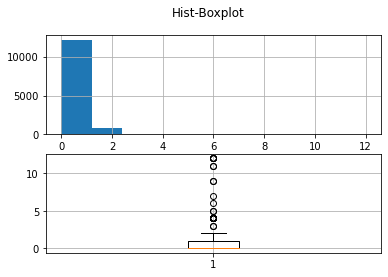

Column name: SpeciesID
NANs: 0
Negatives: 0
Zeros: 0
Positives: 13028

3885      4
3702      4
4565      4
2771      4
4577      4
         ..
2021      1
2026      1
202751    1
202752    1
114524    1
Name: SpeciesID, Length: 12368, dtype: int64



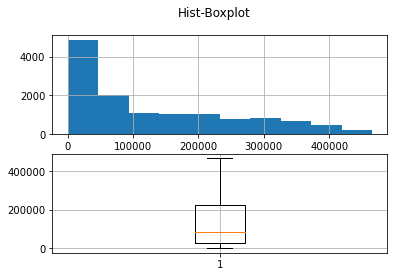

Column name: Ncodons
NANs: 0
Negatives: 0
Zeros: 0
Positives: 13028

1140       67
1784       58
1054       44
1014       39
1047       39
           ..
8238        1
351818      1
2622925     1
572059      1
8998998     1
Name: Ncodons, Length: 7103, dtype: int64



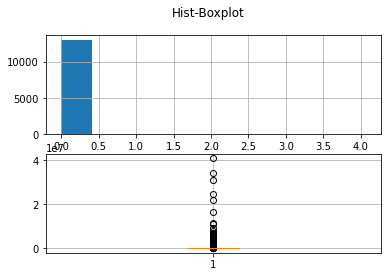

Column name: UUA
NANs: 0
Negatives: 0
Zeros: 460
Positives: 12568

0.00000    460
0.01513     41
0.03748     32
0.00093     17
0.01682     15
          ... 
0.06606      1
0.06425      1
0.01548      1
0.08363      1
0.04059      1
Name: UUA, Length: 4796, dtype: int64



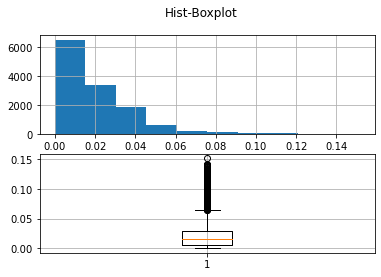

Column name: UUG
NANs: 0
Negatives: 0
Zeros: 452
Positives: 12576

0.00000    452
0.00263     47
0.01035     42
0.03156     34
0.01774     23
          ... 
0.02372      1
0.03017      1
0.03006      1
0.02743      1
0.00619      1
Name: UUG, Length: 3282, dtype: int64



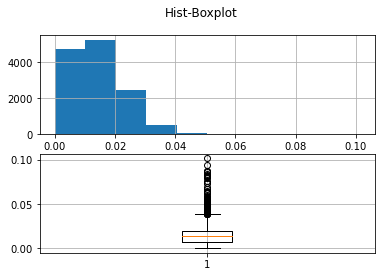

Column name: CUU
NANs: 0
Negatives: 0
Zeros: 35
Positives: 12993

0.02564    43
0.02627    35
0.00000    35
0.01312    22
0.01316    19
           ..
0.02680     1
0.05143     1
0.03224     1
0.00668     1
0.03415     1
Name: CUU, Length: 3677, dtype: int64



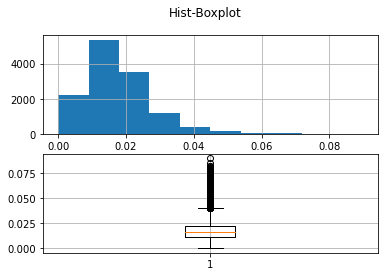

Column name: CUC
NANs: 0
Negatives: 0
Zeros: 241
Positives: 12787

0.00000    241
0.00789     40
0.01513     38
0.00195     26
0.00587     20
          ... 
0.04569      1
0.02333      1
0.01157      1
0.05463      1
0.05042      1
Name: CUC, Length: 4389, dtype: int64



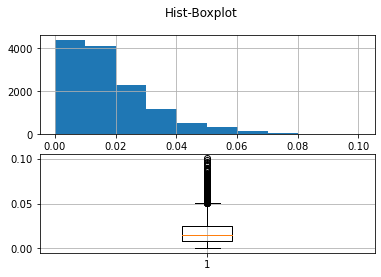

Column name: CUA
NANs: 0
Negatives: 0
Zeros: 275
Positives: 12753

0.00000    275
0.00796     39
0.01775     31
0.01389     24
0.00907     22
          ... 
0.06628      1
0.04931      1
0.05101      1
0.05810      1
0.07604      1
Name: CUA, Length: 4063, dtype: int64



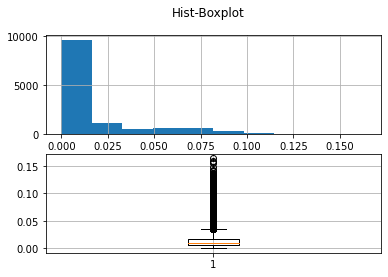

Column name: CUG
NANs: 0
Negatives: 0
Zeros: 223
Positives: 12805

0.00000    223
0.00789     56
0.00318     43
0.00263     30
0.00975     25
          ... 
0.06188      1
0.03148      1
0.04347      1
0.04005      1
0.03555      1
Name: CUG, Length: 4562, dtype: int64



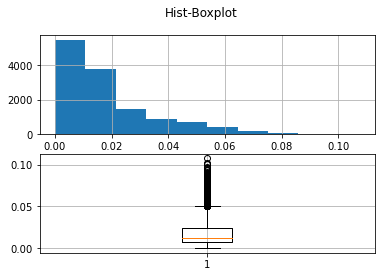

Column name: AUU
NANs: 0
Negatives: 0
Zeros: 51
Positives: 12977

0.00000    51
0.04734    38
0.04220    28
0.02170    15
0.02092    13
           ..
0.00947     1
0.05244     1
0.00486     1
0.00346     1
0.02772     1
Name: AUU, Length: 5243, dtype: int64



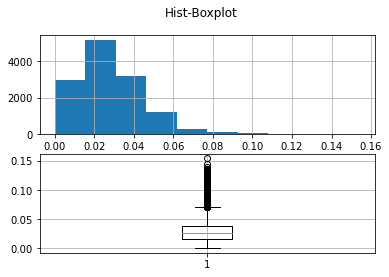

Column name: AUC
NANs: 0
Negatives: 0
Zeros: 15
Positives: 13013

0.00986    47
0.00796    29
0.00992    18
0.01124    17
0.01701    16
           ..
0.01244     1
0.03966     1
0.04367     1
0.01103     1
0.05137     1
Name: AUC, Length: 4684, dtype: int64



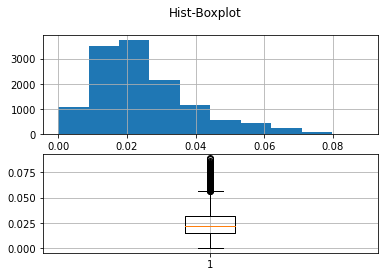

Column name: AUA
NANs: 0
Negatives: 0
Zeros: 289
Positives: 12739

0.00000    289
0.01775     40
0.01115     39
0.02579     29
0.02362     18
          ... 
0.03418      1
0.02831      1
0.03391      1
0.02253      1
0.03435      1
Name: AUA, Length: 4477, dtype: int64



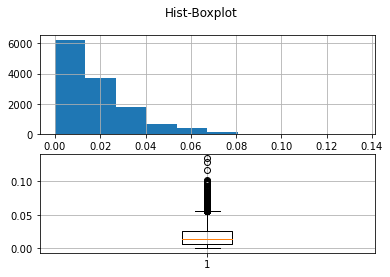

Column name: AUG
NANs: 0
Negatives: 0
Zeros: 13
Positives: 13015

0.00263    46
0.01775    38
0.00789    36
0.01592    35
0.00526    27
           ..
0.03429     1
0.04674     1
0.01220     1
0.03785     1
0.00582     1
Name: AUG, Length: 3237, dtype: int64



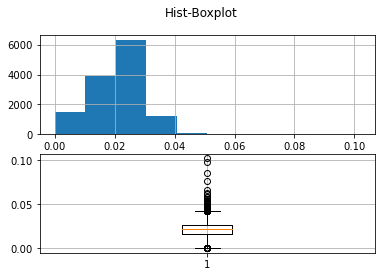

Column name: GUU
NANs: 0
Negatives: 0
Zeros: 106
Positives: 12922

0.00000    106
0.01183     43
0.03901     26
0.00860     25
0.00525     24
          ... 
0.00410      1
0.03243      1
0.03013      1
0.03568      1
0.00629      1
Name: GUU, Length: 3640, dtype: int64



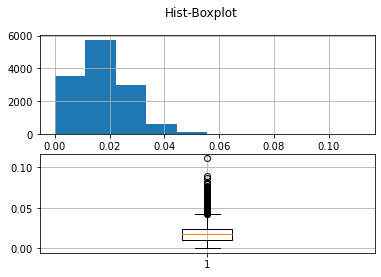

Column name: GUC
NANs: 0
Negatives: 0
Zeros: 94
Positives: 12934

0.00000    94
0.00592    51
0.01513    49
0.01316    30
0.00287    22
           ..
0.02857     1
0.02771     1
0.04375     1
0.05258     1
0.00498     1
Name: GUC, Length: 3602, dtype: int64



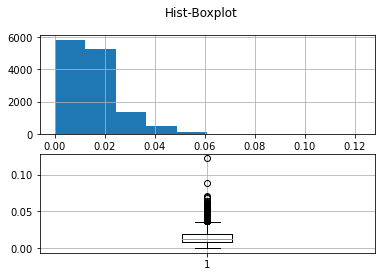

Column name: GUA
NANs: 0
Negatives: 0
Zeros: 111
Positives: 12917

0.00000    111
0.01775     44
0.00955     40
0.00287     26
0.00573     22
          ... 
0.03025      1
0.03952      1
0.02827      1
0.02954      1
0.03358      1
Name: GUA, Length: 3149, dtype: int64



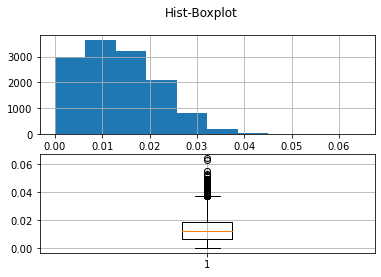

Column name: GUG
NANs: 0
Negatives: 0
Zeros: 418
Positives: 12610

0.00000    418
0.00263     54
0.00592     45
0.01035     36
0.00262     25
          ... 
0.02491      1
0.04024      1
0.03010      1
0.02562      1
0.04154      1
Name: GUG, Length: 3993, dtype: int64



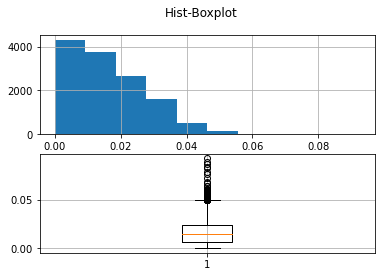

Column name: GCU
NANs: 0
Negatives: 0
Zeros: 21
Positives: 13007

0.01972    36
0.03742    27
0.01316    23
0.01053    22
0.00000    21
           ..
0.00416     1
0.04273     1
0.00255     1
0.03596     1
0.01109     1
Name: GCU, Length: 3725, dtype: int64



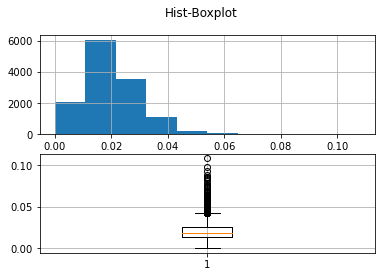

Column name: GCC
NANs: 0
Negatives: 0
Zeros: 86
Positives: 12942

0.00000    86
0.00789    43
0.00955    37
0.02105    25
0.00198    23
           ..
0.05843     1
0.04650     1
0.01482     1
0.08953     1
0.03821     1
Name: GCC, Length: 5044, dtype: int64



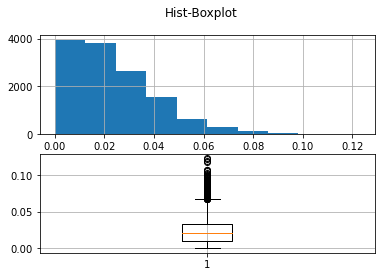

Column name: GCA
NANs: 0
Negatives: 0
Zeros: 25
Positives: 13003

0.00789    41
0.01354    32
0.00000    25
0.02632    24
0.02292    22
           ..
0.01119     1
0.00701     1
0.00051     1
0.01241     1
0.00576     1
Name: GCA, Length: 3451, dtype: int64



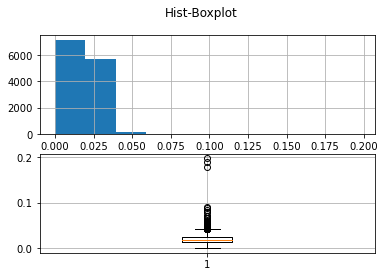

Column name: GCG
NANs: 0
Negatives: 0
Zeros: 831
Positives: 12197

0.00000    831
0.00197     73
0.00398     45
0.00196     42
0.00198     37
          ... 
0.04474      1
0.04151      1
0.03235      1
0.03905      1
0.01990      1
Name: GCG, Length: 3559, dtype: int64



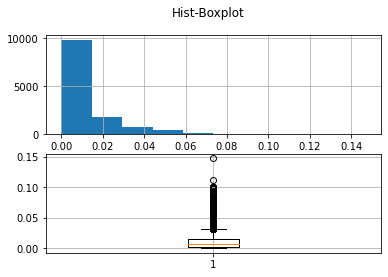

Column name: CCU
NANs: 0
Negatives: 0
Zeros: 53
Positives: 12975

0.00000    53
0.01183    33
0.02707    29
0.00984    25
0.00789    24
           ..
0.02829     1
0.02818     1
0.06183     1
0.00138     1
0.02931     1
Name: CCU, Length: 2751, dtype: int64



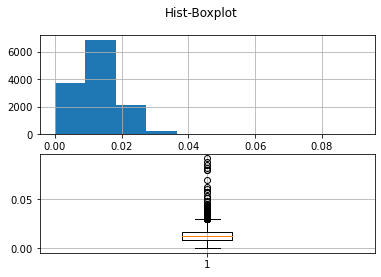

Column name: CCC
NANs: 0
Negatives: 0
Zeros: 204
Positives: 12824

0.00000    204
0.00239     43
0.00787     28
0.01316     23
0.00403     22
          ... 
0.03733      1
0.04898      1
0.03044      1
0.01634      1
0.01979      1
Name: CCC, Length: 3221, dtype: int64



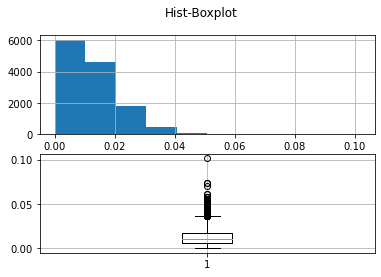

Column name: CCA
NANs: 0
Negatives: 0
Zeros: 69
Positives: 12959

0.00000    69
0.01381    47
0.01513    43
0.00860    35
0.01389    22
           ..
0.02946     1
0.02301     1
0.02200     1
0.00125     1
0.03191     1
Name: CCA, Length: 3488, dtype: int64



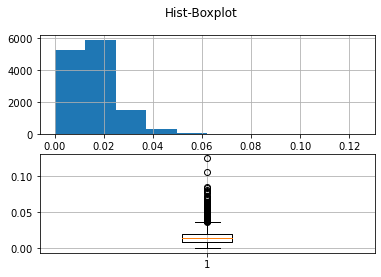

Column name: CCG
NANs: 0
Negatives: 0
Zeros: 753
Positives: 12275

0.00000    753
0.00263     53
0.00159     52
0.00394     36
0.00195     35
          ... 
0.03504      1
0.02262      1
0.03157      1
0.01463      1
0.01332      1
Name: CCG, Length: 2889, dtype: int64



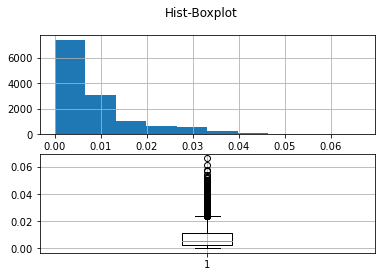

Column name: UGG
NANs: 0
Negatives: 0
Zeros: 406
Positives: 12622

0.00000    406
0.01578     46
0.00263     44
0.00876     44
0.01389     28
          ... 
0.02351      1
0.02395      1
0.03401      1
0.00743      1
0.00433      1
Name: UGG, Length: 2597, dtype: int64



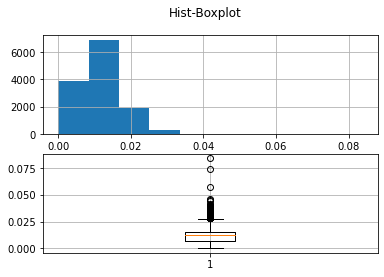

Column name: GGU
NANs: 0
Negatives: 0
Zeros: 134
Positives: 12894

0.00000    134
0.00789     67
0.02468     35
0.00526     30
0.00787     23
          ... 
0.04344      1
0.05880      1
0.03922      1
0.04768      1
0.00237      1
Name: GGU, Length: 3622, dtype: int64



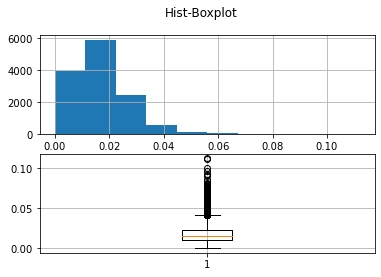

Column name: GGC
NANs: 0
Negatives: 0
Zeros: 176
Positives: 12852

0.00000    176
0.00592     38
0.00197     37
0.00198     32
0.01911     28
          ... 
0.04846      1
0.05385      1
0.05030      1
0.04991      1
0.02163      1
Name: GGC, Length: 4392, dtype: int64



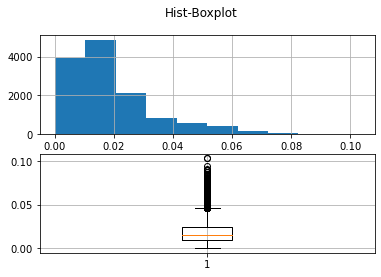

Column name: GGA
NANs: 0
Negatives: 0
Zeros: 34
Positives: 12994

0.01592    48
0.01183    42
0.00000    34
0.01992    20
0.02092    19
           ..
0.03009     1
0.03641     1
0.03859     1
0.04386     1
0.00503     1
Name: GGA, Length: 3538, dtype: int64



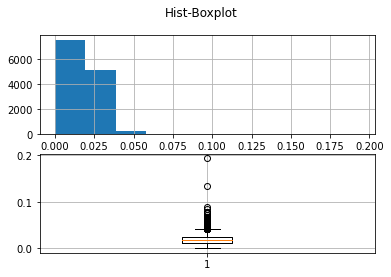

Column name: GGG
NANs: 0
Negatives: 0
Zeros: 201
Positives: 12827

0.00000    201
0.01183     42
0.00263     42
0.00318     40
0.00789     35
          ... 
0.02668      1
0.03329      1
0.02682      1
0.00829      1
0.02129      1
Name: GGG, Length: 2613, dtype: int64



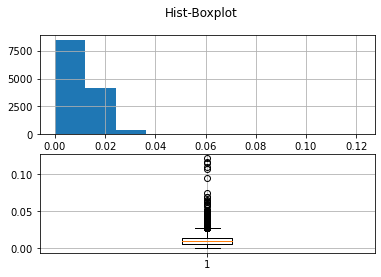

Column name: UCU
NANs: 0
Negatives: 0
Zeros: 131
Positives: 12897

0.00000    131
0.00526     27
0.00573     25
0.00860     24
0.04734     23
          ... 
0.04403      1
0.04599      1
0.04590      1
0.02064      1
0.00626      1
Name: UCU, Length: 3273, dtype: int64



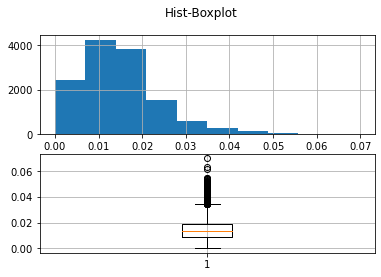

Column name: UCC
NANs: 0
Negatives: 0
Zeros: 104
Positives: 12924

0.00000    104
0.01972     36
0.00478     33
0.01579     22
0.01316     21
          ... 
0.03573      1
0.02828      1
0.03704      1
0.02214      1
0.02995      1
Name: UCC, Length: 2997, dtype: int64



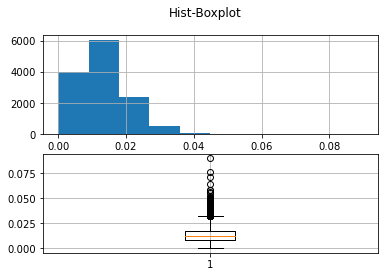

Column name: UCA
NANs: 0
Negatives: 0
Zeros: 103
Positives: 12925

0.00000    103
0.02761     39
0.02309     29
0.02105     22
0.01587     21
          ... 
0.04307      1
0.03622      1
0.03233      1
0.02077      1
0.02371      1
Name: UCA, Length: 3391, dtype: int64



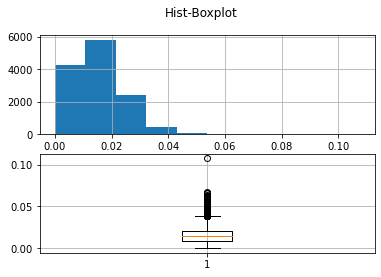

Column name: UCG
NANs: 0
Negatives: 0
Zeros: 816
Positives: 12212

0.00000    816
0.00287     42
0.00239     39
0.00263     36
0.01183     36
          ... 
0.02282      1
0.02093      1
0.01455      1
0.02346      1
0.00009      1
Name: UCG, Length: 2306, dtype: int64



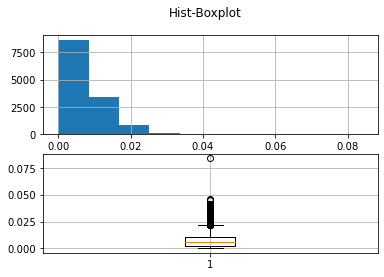

Column name: AGU
NANs: 0
Negatives: 0
Zeros: 591
Positives: 12437

0.00000    591
0.00263     70
0.01381     44
0.00336     33
0.00955     31
          ... 
0.02328      1
0.02397      1
0.02028      1
0.00534      1
0.02090      1
Name: AGU, Length: 2440, dtype: int64



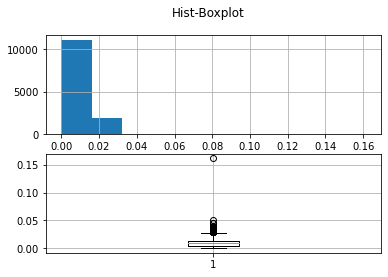

Column name: AGC
NANs: 0
Negatives: 0
Zeros: 196
Positives: 12832

0.00000    196
0.00262     52
0.00394     50
0.00789     45
0.00478     44
          ... 
0.04033      1
0.00236      1
0.00110      1
0.02107      1
0.01958      1
Name: AGC, Length: 2565, dtype: int64



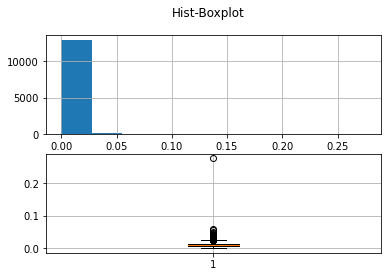

Column name: ACU
NANs: 0
Negatives: 0
Zeros: 70
Positives: 12958

0.00000    70
0.01183    43
0.03662    29
0.00789    25
0.01053    24
           ..
0.03822     1
0.04207     1
0.02945     1
0.00209     1
0.03280     1
Name: ACU, Length: 3253, dtype: int64



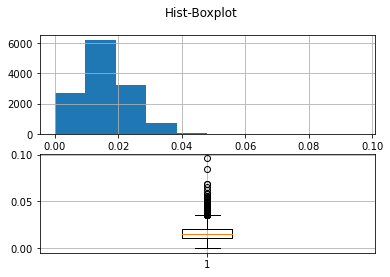

Column name: ACC
NANs: 0
Negatives: 0
Zeros: 71
Positives: 12957

0.00000    71
0.00197    47
0.00955    38
0.00196    30
0.00789    20
           ..
0.04052     1
0.04166     1
0.05027     1
0.04311     1
0.05031     1
Name: ACC, Length: 4188, dtype: int64



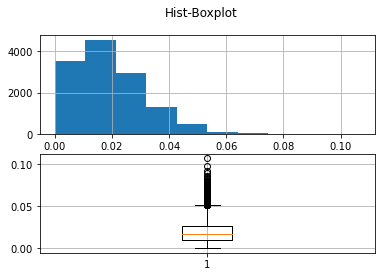

Column name: ACA
NANs: 0
Negatives: 0
Zeros: 100
Positives: 12928

0.00000    100
0.00197     43
0.02866     25
0.00196     22
0.01481     17
          ... 
0.03799      1
0.05570      1
0.04764      1
0.03894      1
0.03446      1
Name: ACA, Length: 4170, dtype: int64



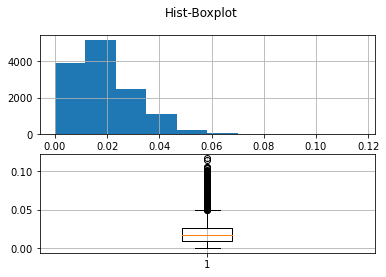

Column name: ACG
NANs: 0
Negatives: 0
Zeros: 646
Positives: 12382

0.00000    646
0.00394     58
0.00263     45
0.00318     43
0.00198     37
          ... 
0.01378      1
0.03322      1
0.03668      1
0.01942      1
0.00013      1
Name: ACG, Length: 2484, dtype: int64



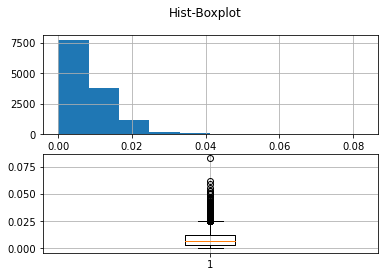

Column name: UAU
NANs: 0
Negatives: 0
Zeros: 122
Positives: 12906

0.00000    122
0.04536     31
0.00573     26
0.02787     25
0.00576     24
          ... 
0.00941      1
0.03430      1
0.00449      1
0.03611      1
0.00994      1
Name: UAU, Length: 3977, dtype: int64



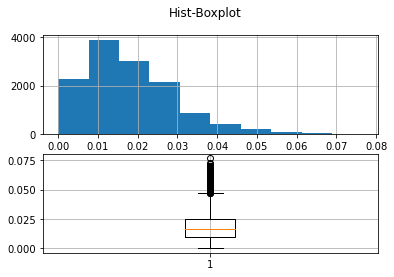

Column name: UAC
NANs: 0
Negatives: 0
Zeros: 36
Positives: 12992

0.01433    53
0.00986    44
0.00000    36
0.01441    27
0.01719    25
           ..
0.04339     1
0.03076     1
0.03410     1
0.00612     1
0.02223     1
Name: UAC, Length: 3003, dtype: int64



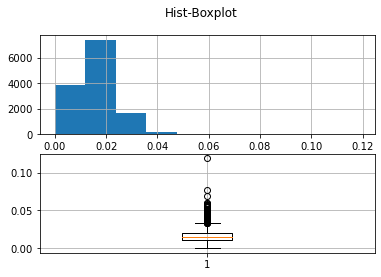

Column name: CAA
NANs: 0
Negatives: 0
Zeros: 54
Positives: 12974

0.01579    63
0.00000    54
0.02367    46
0.03503    36
0.01842    34
           ..
0.00982     1
0.03634     1
0.03823     1
0.01012     1
0.05165     1
Name: CAA, Length: 3670, dtype: int64



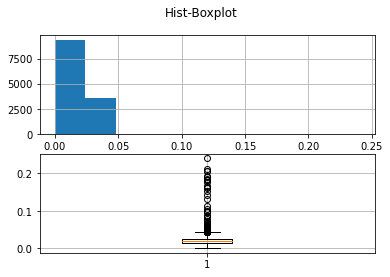

Column name: CAG
NANs: 0
Negatives: 0
Zeros: 452
Positives: 12576

0.00000    452
0.00789     46
0.00263     39
0.00262     36
0.00287     25
          ... 
0.07205      1
0.06577      1
0.04276      1
0.07699      1
0.03423      1
Name: CAG, Length: 3724, dtype: int64



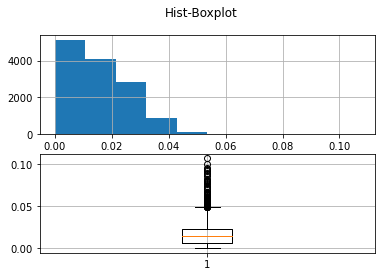

Column name: AAU
NANs: 0
Negatives: 0
Zeros: 60
Positives: 12968

0.00000    60
0.04536    38
0.00860    20
0.04140    20
0.00789    19
           ..
0.00160     1
0.05670     1
0.03411     1
0.05444     1
0.01351     1
Name: AAU, Length: 4661, dtype: int64



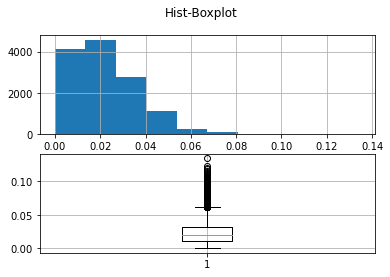

Column name: AAC
NANs: 0
Negatives: 0
Zeros: 24
Positives: 13004

0.00986    40
0.02229    35
0.00000    24
0.01433    20
0.02632    20
           ..
0.00553     1
0.00538     1
0.00526     1
0.03651     1
0.03683     1
Name: AAC, Length: 3675, dtype: int64



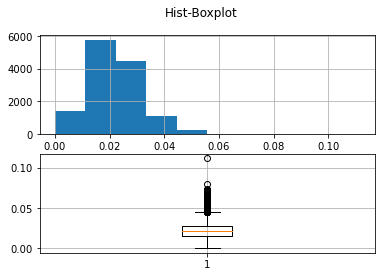

Column name: UGU
NANs: 0
Negatives: 0
Zeros: 839
Positives: 12189

0.00000    839
0.00263     76
0.00986     52
0.00336     32
0.00264     31
          ... 
0.01925      1
0.02870      1
0.02368      1
0.02979      1
0.01779      1
Name: UGU, Length: 2205, dtype: int64



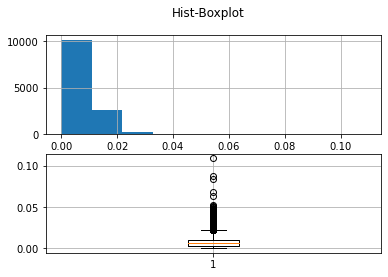

Column name: UGC
NANs: 0
Negatives: 0
Zeros: 508
Positives: 12520

0.00000    508
0.00287     59
0.00789     53
0.01053     50
0.00787     39
          ... 
0.01945      1
0.01289      1
0.01534      1
0.01595      1
0.02461      1
Name: UGC, Length: 2196, dtype: int64



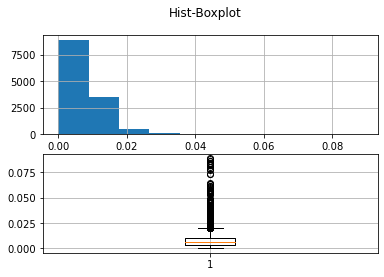

Column name: CAU
NANs: 0
Negatives: 0
Zeros: 147
Positives: 12881

0.00000    147
0.01035     43
0.00860     38
0.01053     35
0.01316     33
          ... 
0.00158      1
0.01853      1
0.02815      1
0.02254      1
0.02540      1
Name: CAU, Length: 2615, dtype: int64



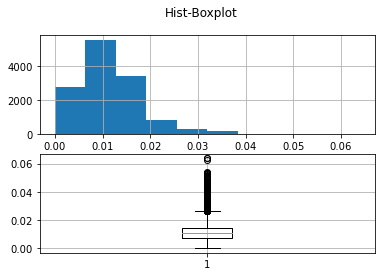

Column name: CAC
NANs: 0
Negatives: 0
Zeros: 88
Positives: 12940

0.00000    88
0.00789    47
0.00159    37
0.01433    23
0.01146    22
           ..
0.04634     1
0.02309     1
0.00137     1
0.02746     1
0.01802     1
Name: CAC, Length: 2668, dtype: int64



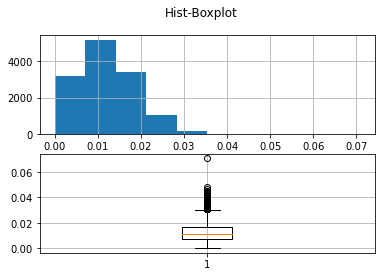

Column name: AAA
NANs: 0
Negatives: 0
Zeros: 57
Positives: 12971

0.00000    57
0.02368    41
0.02362    37
0.04339    35
0.02632    28
           ..
0.00531     1
0.00160     1
0.07862     1
0.09140     1
0.02359     1
Name: AAA, Length: 5288, dtype: int64



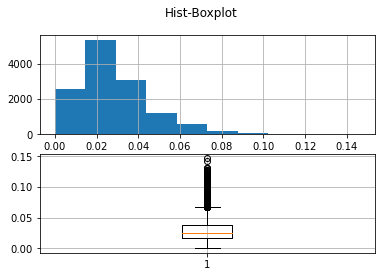

Column name: AAG
NANs: 0
Negatives: 0
Zeros: 405
Positives: 12623

0.00000    405
0.00263     65
0.01972     36
0.02070     32
0.00262     32
          ... 
0.07888      1
0.04640      1
0.04030      1
0.04540      1
0.04366      1
Name: AAG, Length: 4532, dtype: int64



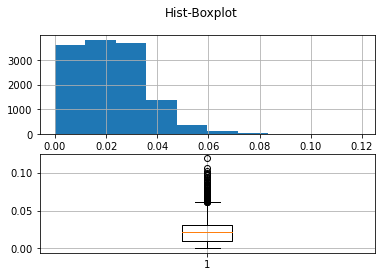

Column name: CGU
NANs: 0
Negatives: 0
Zeros: 579
Positives: 12449

0.00000    579
0.00263     86
0.00287     68
0.00557     43
0.00262     36
          ... 
0.01690      1
0.01899      1
0.02433      1
0.02224      1
0.00039      1
Name: CGU, Length: 2298, dtype: int64



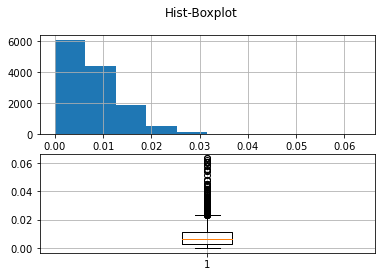

Column name: CGC
NANs: 0
Negatives: 0
Zeros: 506
Positives: 12522

0.00000    506
0.00526     72
0.00263     54
0.00592     54
0.00288     48
          ... 
0.03565      1
0.05390      1
0.03538      1
0.02721      1
0.02094      1
Name: CGC, Length: 3182, dtype: int64



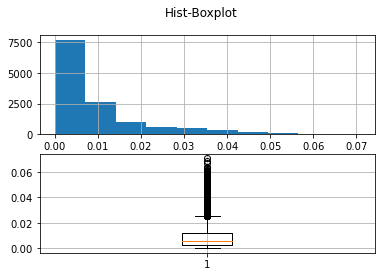

Column name: CGA
NANs: 0
Negatives: 0
Zeros: 337
Positives: 12691

0.00000    337
0.01316     50
0.01579     49
0.00318     43
0.00576     38
          ... 
0.02185      1
0.01818      1
0.02170      1
0.01881      1
0.01248      1
Name: CGA, Length: 1880, dtype: int64



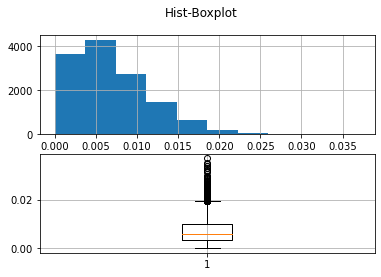

Column name: CGG
NANs: 0
Negatives: 0
Zeros: 1399
Positives: 11629

0.00000    1399
0.00394      57
0.00159      43
0.00263      43
0.00057      39
           ... 
0.01944       1
0.01939       1
0.03009       1
0.01278       1
0.01037       1
Name: CGG, Length: 2136, dtype: int64



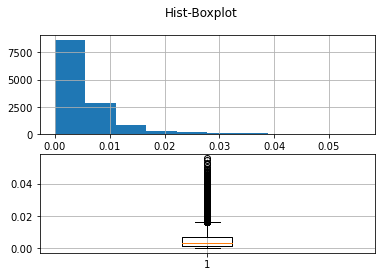

Column name: AGA
NANs: 0
Negatives: 0
Zeros: 1772
Positives: 11256

0.00000    1772
0.00263     161
0.02170      37
0.00034      31
0.00264      28
           ... 
0.03982       1
0.02182       1
0.04169       1
0.00480       1
0.00846       1
Name: AGA, Length: 2835, dtype: int64



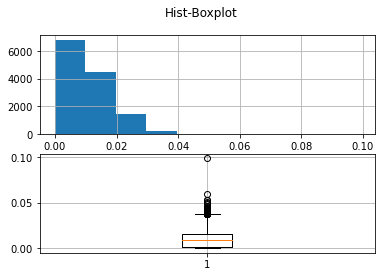

Column name: AGG
NANs: 0
Negatives: 0
Zeros: 2230
Positives: 10798

0.00000    2230
0.00986      43
0.00391      37
0.00056      36
0.00198      34
           ... 
0.01745       1
0.01993       1
0.02074       1
0.01471       1
0.01333       1
Name: AGG, Length: 2228, dtype: int64



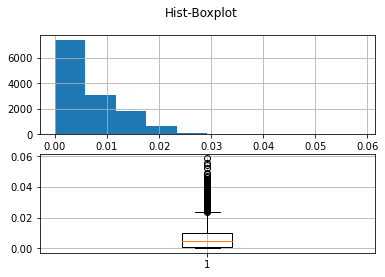

Column name: GAU
NANs: 0
Negatives: 0
Zeros: 261
Positives: 12767

0.00000    261
0.02367     41
0.03901     31
0.00526     29
0.00789     28
          ... 
0.04612      1
0.04658      1
0.04981      1
0.01680      1
0.00451      1
Name: GAU, Length: 4578, dtype: int64



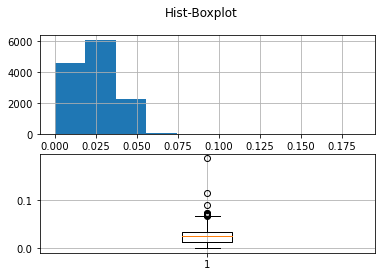

Column name: GAC
NANs: 0
Negatives: 0
Zeros: 114
Positives: 12914

0.00000    114
0.00789     45
0.00287     37
0.01842     32
0.01911     29
          ... 
0.00695      1
0.05964      1
0.00776      1
0.05169      1
0.03401      1
Name: GAC, Length: 4416, dtype: int64



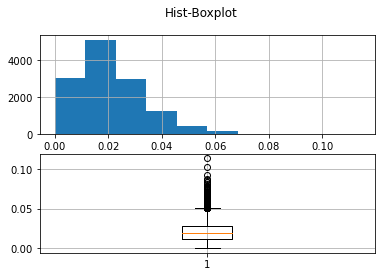

Column name: GAA
NANs: 0
Negatives: 0
Zeros: 16
Positives: 13012

0.01316    55
0.01579    52
0.01433    41
0.03353    35
0.01837    27
           ..
0.05991     1
0.04862     1
0.04214     1
0.04971     1
0.00744     1
Name: GAA, Length: 4827, dtype: int64



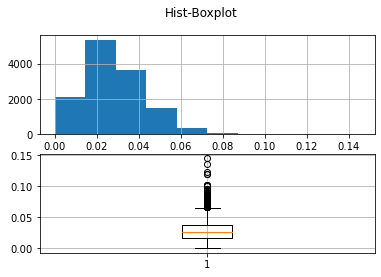

Column name: GAG
NANs: 0
Negatives: 0
Zeros: 438
Positives: 12590

0.00000    438
0.00263     45
0.01381     36
0.01672     33
0.00287     20
          ... 
0.06047      1
0.00832      1
0.01108      1
0.08218      1
0.03689      1
Name: GAG, Length: 4686, dtype: int64



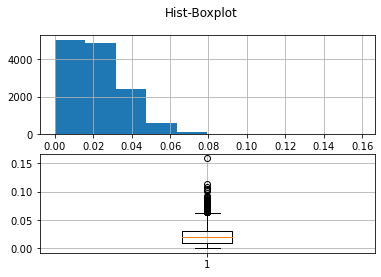

Column name: UAA
NANs: 0
Negatives: 0
Zeros: 1812
Positives: 11216

0.00000    1812
0.00046     122
0.00287      97
0.00262      92
0.00080      84
           ... 
0.00645       1
0.02411       1
0.00332       1
0.03484       1
0.00860       1
Name: UAA, Length: 703, dtype: int64



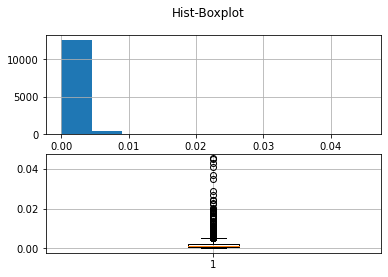

Column name: UAG
NANs: 0
Negatives: 0
Zeros: 4329
Positives: 8699

0.00000    4329
0.00090     123
0.00056     119
0.00044     113
0.00047     110
           ... 
0.00831       1
0.00407       1
0.00396       1
0.00347       1
0.00321       1
Name: UAG, Length: 422, dtype: int64



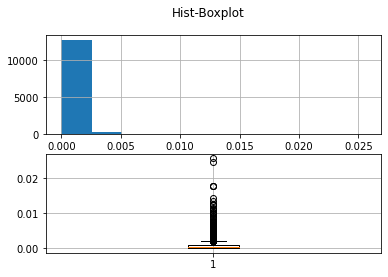

Column name: UGA
NANs: 0
Negatives: 0
Zeros: 2145
Positives: 10883

0.00000    2145
0.00197      98
0.00090      80
0.00196      71
0.00091      70
           ... 
0.01336       1
0.01138       1
0.02055       1
0.00887       1
0.00638       1
Name: UGA, Length: 1786, dtype: int64



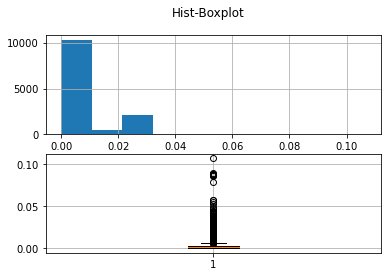

In [ ]:
print(df.shape)
preview_dataset(df)

In [ ]:
df.columns

Index(['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'UUU',
       'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA'],
      dtype='object')

In [ ]:
df.dtypes

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
                ...   
GAA            float64
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Length: 69, dtype: object

array([[<AxesSubplot:title={'center':'DNAtype'}>,
        <AxesSubplot:title={'center':'SpeciesID'}>],
       [<AxesSubplot:title={'center':'Ncodons'}>,
        <AxesSubplot:title={'center':'CUC'}>]], dtype=object)

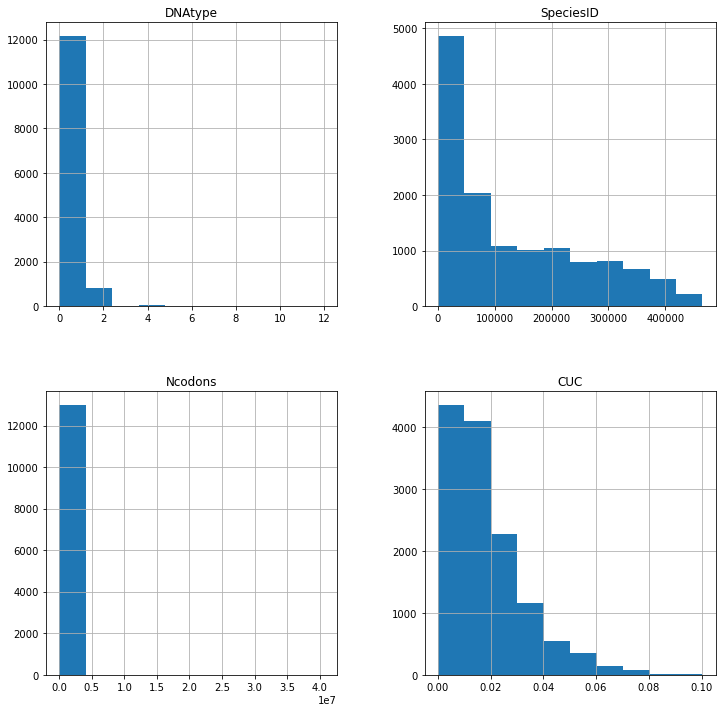

In [ ]:
df[["DNAtype", "SpeciesID", "Ncodons", "CUC"]].hist(figsize=(12, 12))

In [ ]:
plot_hist(df, option=1)

In [ ]:
# Only for test follow algoritmh
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data  # we only take the first two features for visualization
y = iris.target

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
y.dtype

## **Preprocessing**

In [ ]:
df.dtypes

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
                ...   
GAA            float64
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Length: 69, dtype: object

In [ ]:
encoder = preprocessing.LabelEncoder()
df["Kingdom"] = encoder.fit_transform(df["Kingdom"])

In [ ]:
df.dtypes

Kingdom          int64
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
                ...   
GAA            float64
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Length: 69, dtype: object

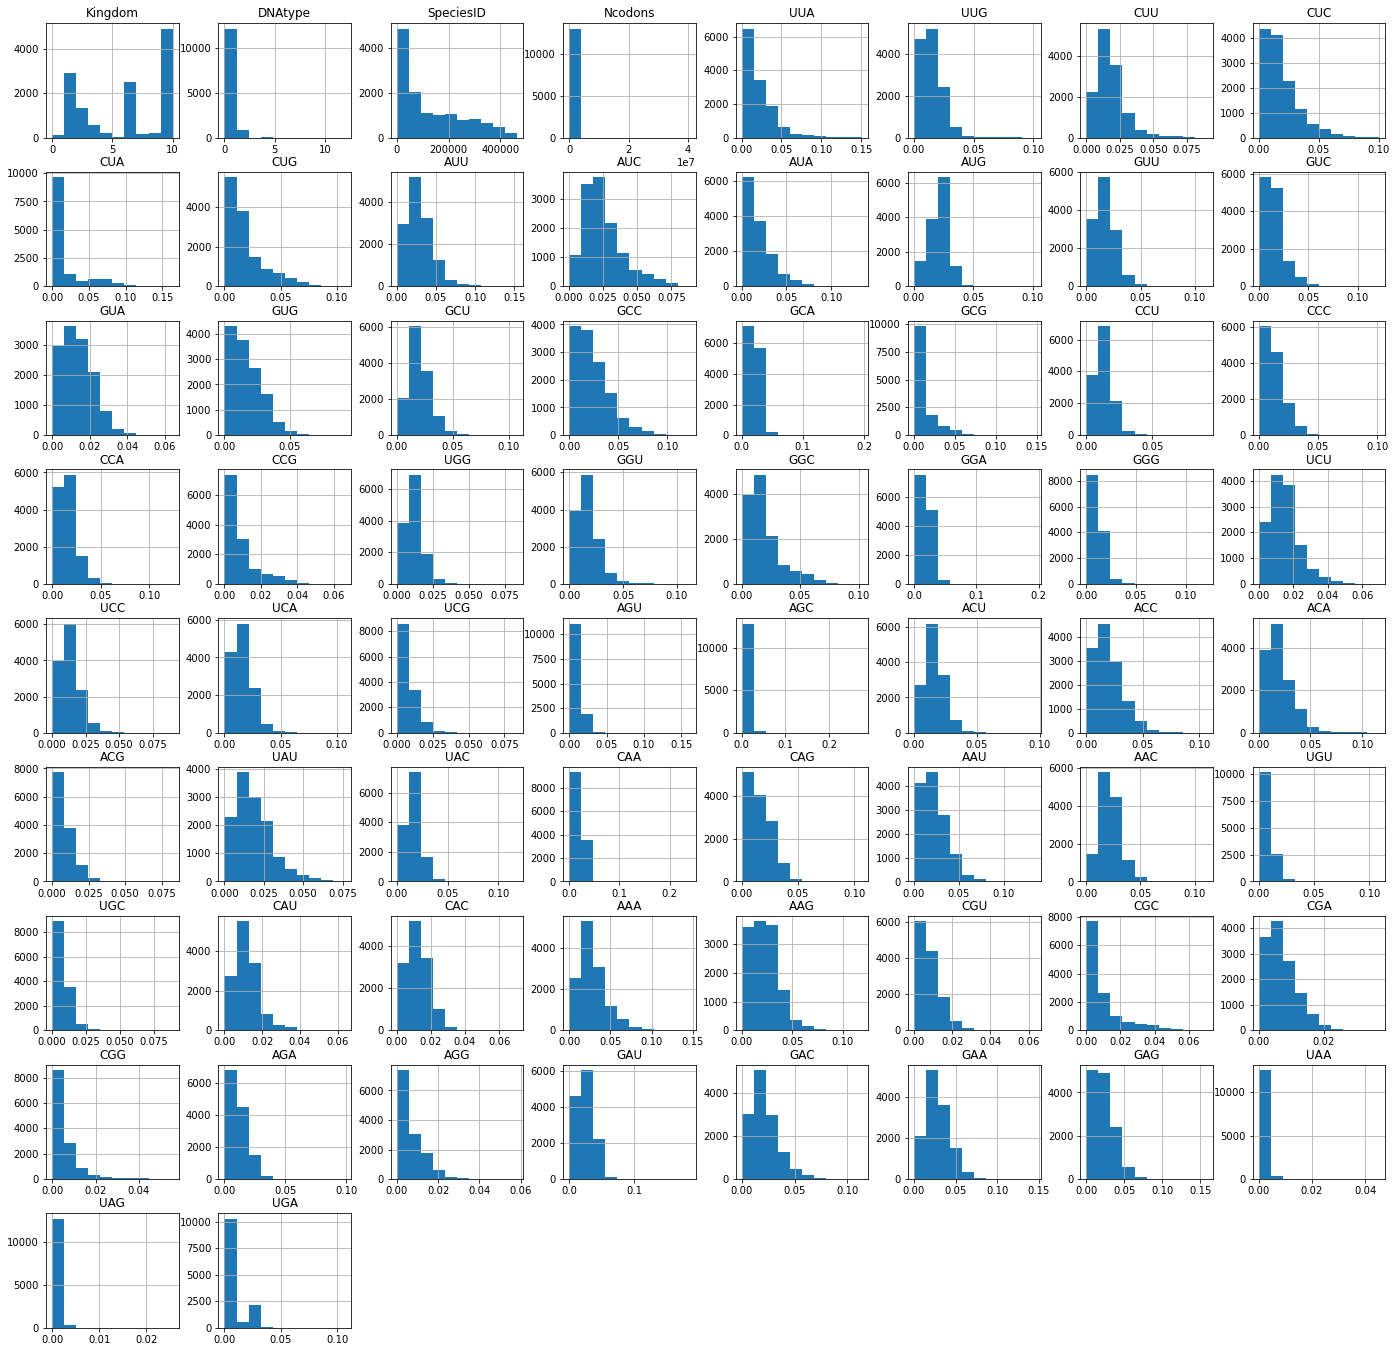

In [ ]:
plot_hist(df, option=1)

In [ ]:
df.drop(columns=["SpeciesID", "SpeciesName"], inplace=True) # "Ncodons"

In [ ]:
df.shape

(13028, 67)

In [ ]:
df["Kingdom"].value_counts(ascending=True, dropna=False)

5       18
0      126
7      180
8      215
4      220
3      572
2     1345
10    2077
6     2523
9     2832
1     2920
Name: Kingdom, dtype: int64

In [ ]:
df["DNAtype"].value_counts(ascending=True, dropna=False)

6        1
7        1
3        2
9        2
5        2
11       2
12       5
4       31
2      816
1     2899
0     9267
Name: DNAtype, dtype: int64

In [ ]:
df.drop(df[df["Kingdom"] == 5].index, inplace=True)

df.drop(df[df["DNAtype"] == 6].index, inplace=True)
df.drop(df[df["DNAtype"] == 7].index, inplace=True)
df.drop(df[df["DNAtype"] == 3].index, inplace=True)
df.drop(df[df["DNAtype"] == 9].index, inplace=True)
df.drop(df[df["DNAtype"] == 5].index, inplace=True)
df.drop(df[df["DNAtype"] == 11].index, inplace=True)
df.drop(df[df["DNAtype"] == 12].index, inplace=True)
df.drop(df[df["DNAtype"] == 4].index, inplace=True)

In [ ]:
df.shape

(12964, 67)

In [ ]:
df["Kingdom"].value_counts(ascending=True, dropna=False)

0      126
7      180
8      215
4      220
3      572
2     1334
10    2077
6     2490
9     2832
1     2918
Name: Kingdom, dtype: int64

In [ ]:
df["DNAtype"].value_counts(ascending=True, dropna=False)

2     816
1    2899
0    9249
Name: DNAtype, dtype: int64

In [ ]:
df.dtypes

Kingdom      int64
DNAtype      int64
Ncodons      int64
UUU         object
UUC         object
            ...   
GAA        float64
GAG        float64
UAA        float64
UAG        float64
UGA        float64
Length: 67, dtype: object

In [ ]:
# df["UUU"] = df["UUU"].astype("float") # ValueError: could not convert string to float
df["UUU"] = pd.to_numeric(df["UUU"], errors="coerce")
df["UUC"] = pd.to_numeric(df["UUC"], errors="coerce")

In [ ]:
df.dtypes

Kingdom      int64
DNAtype      int64
Ncodons      int64
UUU        float64
UUC        float64
            ...   
GAA        float64
GAG        float64
UAA        float64
UAG        float64
UGA        float64
Length: 67, dtype: object

In [ ]:
df.isnull().sum()

Kingdom    0
DNAtype    0
Ncodons    0
UUU        2
UUC        1
          ..
GAA        0
GAG        0
UAA        0
UAG        0
UGA        0
Length: 67, dtype: int64

(12964, 67)
Column name: Kingdom
NANs: 0
Negatives: 0
Zeros: 126
Positives: 12838

1     2918
9     2832
6     2490
10    2077
2     1334
3      572
4      220
8      215
7      180
0      126
Name: Kingdom, dtype: int64



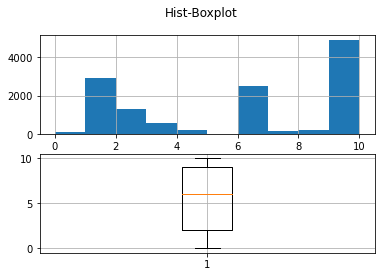

Column name: DNAtype
NANs: 0
Negatives: 0
Zeros: 9249
Positives: 3715

0    9249
1    2899
2     816
Name: DNAtype, dtype: int64



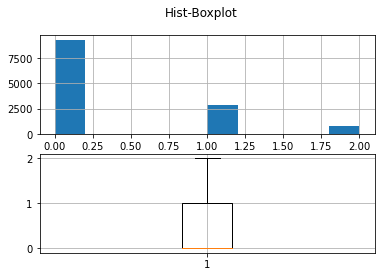

Column name: Ncodons
NANs: 0
Negatives: 0
Zeros: 0
Positives: 12964

1140       67
1784       58
1054       44
1047       39
1014       39
           ..
38314       1
1774174     1
17263       1
3825        1
8998998     1
Name: Ncodons, Length: 7083, dtype: int64



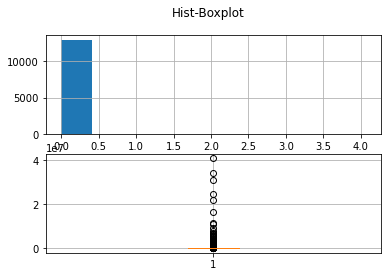

Column name: UUU
NANs: 2
Negatives: 0
Zeros: 81
Positives: 12881

0.00000    81
0.04536    34
0.04618    28
0.01761    17
0.01423    17
           ..
0.00435     1
0.04725     1
0.05056     1
0.00728     1
0.00554     1
Name: UUU, Length: 4763, dtype: int64



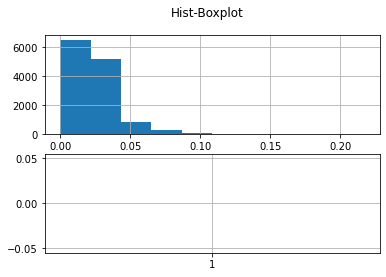

Column name: UUC
NANs: 1
Negatives: 0
Zeros: 16
Positives: 12947

0.01911    43
0.02564    42
0.01134    19
0.01433    19
0.01190    18
           ..
0.00326     1
0.04537     1
0.02752     1
0.02509     1
0.03555     1
Name: UUC, Length: 4114, dtype: int64



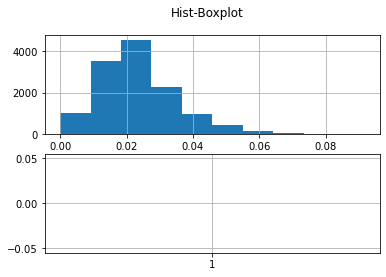

Column name: UUA
NANs: 0
Negatives: 0
Zeros: 459
Positives: 12505

0.00000    459
0.01513     41
0.03748     32
0.00093     17
0.01682     15
          ... 
0.02903      1
0.08868      1
0.07155      1
0.07032      1
0.04059      1
Name: UUA, Length: 4776, dtype: int64



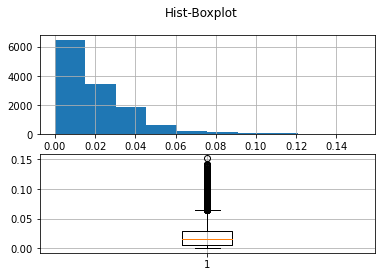

Column name: UUG
NANs: 0
Negatives: 0
Zeros: 450
Positives: 12514

0.00000    450
0.00263     47
0.01035     42
0.03156     34
0.01774     22
          ... 
0.02704      1
0.04094      1
0.02667      1
0.02697      1
0.00619      1
Name: UUG, Length: 3269, dtype: int64



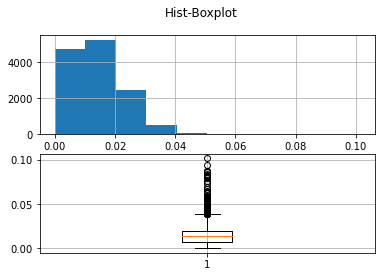

Column name: CUU
NANs: 0
Negatives: 0
Zeros: 35
Positives: 12929

0.02564    43
0.00000    35
0.02627    35
0.01312    22
0.00945    19
           ..
0.03658     1
0.02121     1
0.03337     1
0.00913     1
0.03415     1
Name: CUU, Length: 3675, dtype: int64



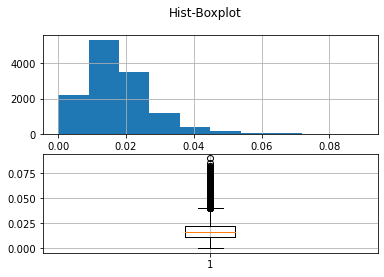

Column name: CUC
NANs: 0
Negatives: 0
Zeros: 234
Positives: 12730

0.00000    234
0.00789     40
0.01513     38
0.00587     20
0.00794     20
          ... 
0.02333      1
0.01157      1
0.05463      1
0.03761      1
0.05042      1
Name: CUC, Length: 4387, dtype: int64



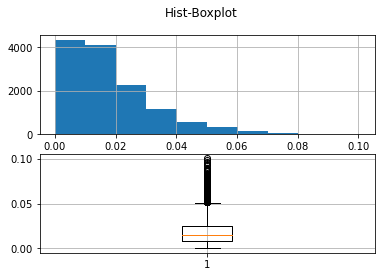

Column name: CUA
NANs: 0
Negatives: 0
Zeros: 275
Positives: 12689

0.00000    275
0.00796     39
0.01775     31
0.01389     24
0.01039     22
          ... 
0.05624      1
0.04199      1
0.04736      1
0.04045      1
0.07604      1
Name: CUA, Length: 4058, dtype: int64



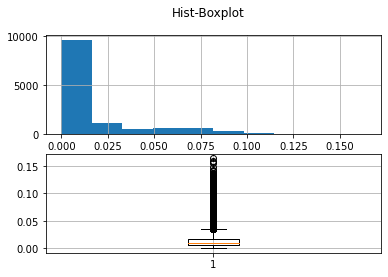

Column name: CUG
NANs: 0
Negatives: 0
Zeros: 220
Positives: 12744

0.00000    220
0.00789     56
0.00318     43
0.00263     30
0.00975     25
          ... 
0.03853      1
0.05455      1
0.06188      1
0.03148      1
0.03555      1
Name: CUG, Length: 4555, dtype: int64



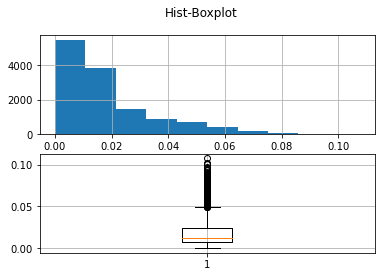

Column name: AUU
NANs: 0
Negatives: 0
Zeros: 51
Positives: 12913

0.00000    51
0.04734    38
0.04220    28
0.02170    15
0.02092    13
           ..
0.05244     1
0.00486     1
0.00346     1
0.00461     1
0.02772     1
Name: AUU, Length: 5228, dtype: int64



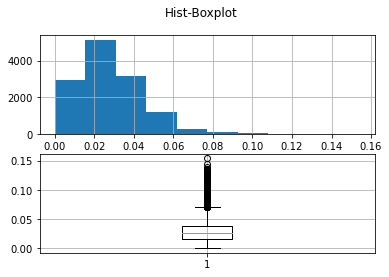

Column name: AUC
NANs: 0
Negatives: 0
Zeros: 15
Positives: 12949

0.00986    47
0.00796    29
0.01124    17
0.00992    17
0.01701    16
           ..
0.02370     1
0.03557     1
0.00625     1
0.00909     1
0.05137     1
Name: AUC, Length: 4679, dtype: int64



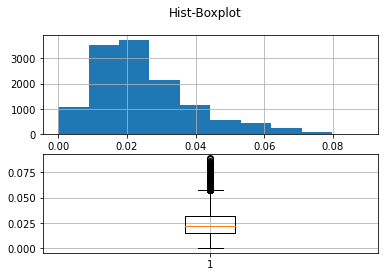

Column name: AUA
NANs: 0
Negatives: 0
Zeros: 289
Positives: 12675

0.00000    289
0.01775     40
0.01115     39
0.02579     29
0.02362     18
          ... 
0.05589      1
0.04424      1
0.02256      1
0.04753      1
0.03435      1
Name: AUA, Length: 4467, dtype: int64



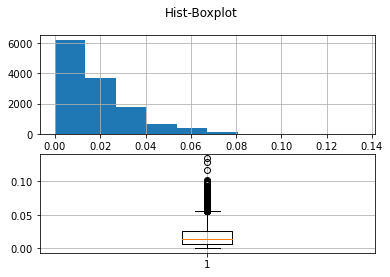

Column name: AUG
NANs: 0
Negatives: 0
Zeros: 13
Positives: 12951

0.00263    46
0.01775    38
0.00789    36
0.01592    35
0.00526    27
           ..
0.04674     1
0.01220     1
0.03785     1
0.04214     1
0.00582     1
Name: AUG, Length: 3232, dtype: int64



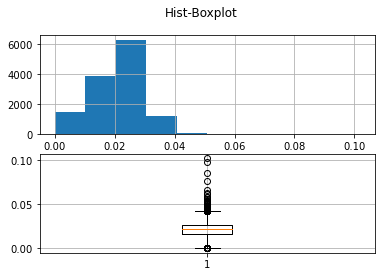

Column name: GUU
NANs: 0
Negatives: 0
Zeros: 106
Positives: 12858

0.00000    106
0.01183     43
0.03901     26
0.00860     25
0.00288     24
          ... 
0.03443      1
0.03257      1
0.00238      1
0.03600      1
0.00629      1
Name: GUU, Length: 3635, dtype: int64



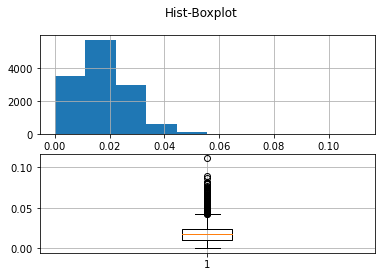

Column name: GUC
NANs: 0
Negatives: 0
Zeros: 90
Positives: 12874

0.00000    90
0.00592    50
0.01513    49
0.01316    29
0.00391    22
           ..
0.04375     1
0.05258     1
0.03563     1
0.04131     1
0.00498     1
Name: GUC, Length: 3599, dtype: int64



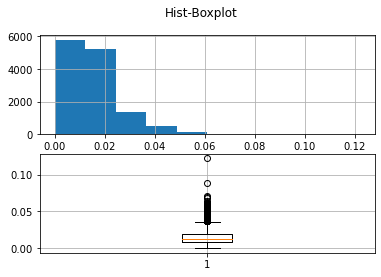

Column name: GUA
NANs: 0
Negatives: 0
Zeros: 111
Positives: 12853

0.00000    111
0.01775     44
0.00955     40
0.00287     26
0.00573     22
          ... 
0.03025      1
0.03952      1
0.02827      1
0.02385      1
0.03358      1
Name: GUA, Length: 3148, dtype: int64



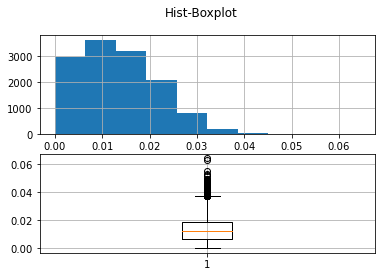

Column name: GUG
NANs: 0
Negatives: 0
Zeros: 416
Positives: 12548

0.00000    416
0.00263     54
0.00592     45
0.01035     36
0.00262     25
          ... 
0.03930      1
0.03167      1
0.02296      1
0.04702      1
0.04154      1
Name: GUG, Length: 3989, dtype: int64



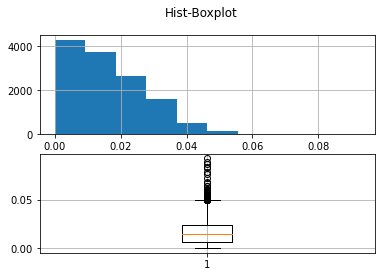

Column name: GCU
NANs: 0
Negatives: 0
Zeros: 21
Positives: 12943

0.01972    36
0.03742    27
0.01316    23
0.01053    22
0.00789    21
           ..
0.04142     1
0.00475     1
0.00604     1
0.00684     1
0.01109     1
Name: GCU, Length: 3716, dtype: int64



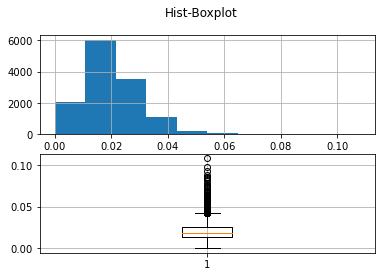

Column name: GCC
NANs: 0
Negatives: 0
Zeros: 85
Positives: 12879

0.00000    85
0.00789    43
0.00955    37
0.02105    25
0.00978    21
           ..
0.05192     1
0.09092     1
0.04560     1
0.04456     1
0.03821     1
Name: GCC, Length: 5033, dtype: int64



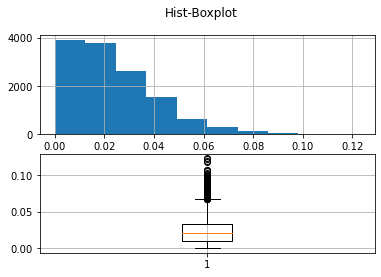

Column name: GCA
NANs: 0
Negatives: 0
Zeros: 25
Positives: 12939

0.00789    41
0.01354    32
0.00000    25
0.02632    24
0.02292    22
           ..
0.01241     1
0.00801     1
0.00179     1
0.00473     1
0.00576     1
Name: GCA, Length: 3446, dtype: int64



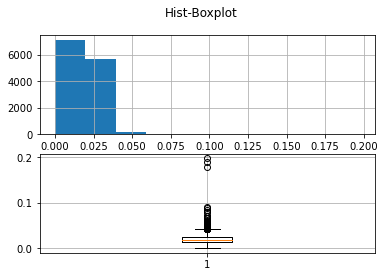

Column name: GCG
NANs: 0
Negatives: 0
Zeros: 819
Positives: 12145

0.00000    819
0.00197     73
0.00398     45
0.00196     42
0.00198     37
          ... 
0.03235      1
0.03905      1
0.04885      1
0.04876      1
0.01990      1
Name: GCG, Length: 3551, dtype: int64



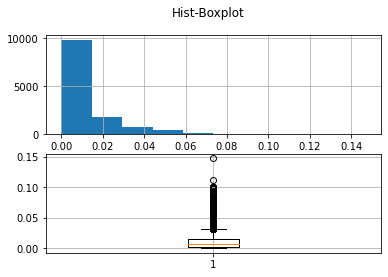

Column name: CCU
NANs: 0
Negatives: 0
Zeros: 53
Positives: 12911

0.00000    53
0.01183    33
0.02707    29
0.00984    25
0.00986    24
           ..
0.00157     1
0.02818     1
0.06183     1
0.00138     1
0.02931     1
Name: CCU, Length: 2750, dtype: int64



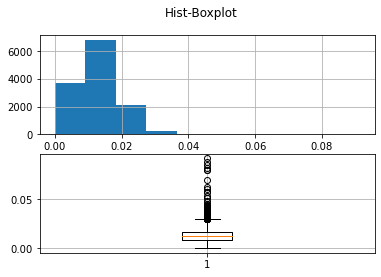

Column name: CCC
NANs: 0
Negatives: 0
Zeros: 202
Positives: 12762

0.00000    202
0.00239     43
0.00787     28
0.01316     23
0.00403     22
          ... 
0.03019      1
0.05124      1
0.02700      1
0.03733      1
0.01979      1
Name: CCC, Length: 3221, dtype: int64



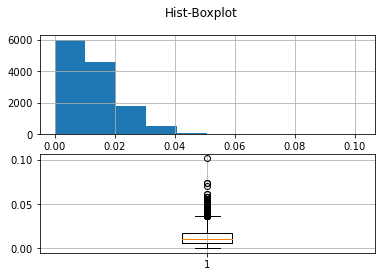

Column name: CCA
NANs: 0
Negatives: 0
Zeros: 69
Positives: 12895

0.00000    69
0.01381    47
0.01513    43
0.00860    35
0.01389    22
           ..
0.00202     1
0.03110     1
0.02821     1
0.03411     1
0.03191     1
Name: CCA, Length: 3488, dtype: int64



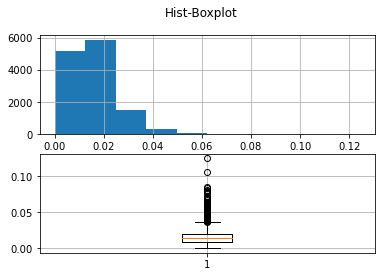

Column name: CCG
NANs: 0
Negatives: 0
Zeros: 747
Positives: 12217

0.00000    747
0.00263     53
0.00159     52
0.00394     36
0.00196     33
          ... 
0.03487      1
0.01343      1
0.02081      1
0.02792      1
0.01332      1
Name: CCG, Length: 2884, dtype: int64



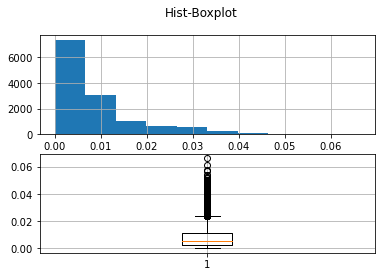

Column name: UGG
NANs: 0
Negatives: 0
Zeros: 405
Positives: 12559

0.00000    405
0.01578     46
0.00263     44
0.00876     44
0.01389     28
          ... 
0.02020      1
0.03774      1
0.02712      1
0.02087      1
0.00433      1
Name: UGG, Length: 2596, dtype: int64



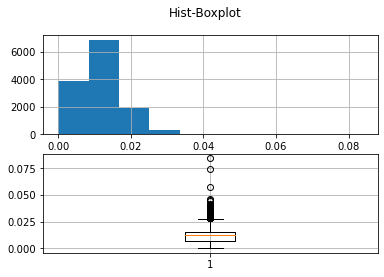

Column name: GGU
NANs: 0
Negatives: 0
Zeros: 134
Positives: 12830

0.00000    134
0.00789     67
0.02468     35
0.00526     30
0.00787     23
          ... 
0.02707      1
0.03432      1
0.04107      1
0.03338      1
0.00237      1
Name: GGU, Length: 3616, dtype: int64



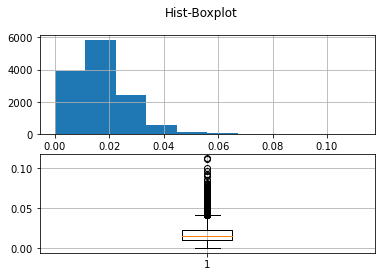

Column name: GGC
NANs: 0
Negatives: 0
Zeros: 175
Positives: 12789

0.00000    175
0.00592     38
0.00197     36
0.00198     29
0.01911     28
          ... 
0.04798      1
0.02282      1
0.06449      1
0.03828      1
0.02163      1
Name: GGC, Length: 4383, dtype: int64



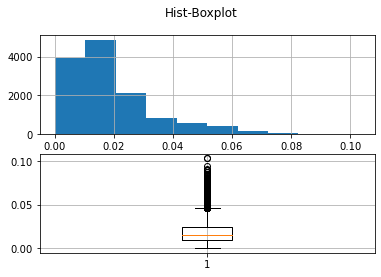

Column name: GGA
NANs: 0
Negatives: 0
Zeros: 34
Positives: 12930

0.01592    48
0.01183    42
0.00000    34
0.01992    20
0.02092    19
           ..
0.03641     1
0.03300     1
0.03009     1
0.04386     1
0.00503     1
Name: GGA, Length: 3538, dtype: int64



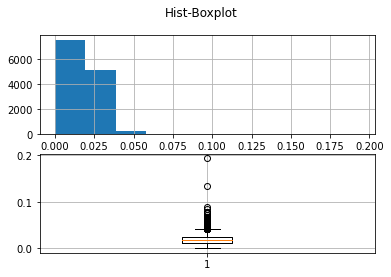

Column name: GGG
NANs: 0
Negatives: 0
Zeros: 199
Positives: 12765

0.00000    199
0.01183     42
0.00263     41
0.00318     39
0.00789     35
          ... 
0.03444      1
0.02668      1
0.03329      1
0.02682      1
0.02129      1
Name: GGG, Length: 2611, dtype: int64



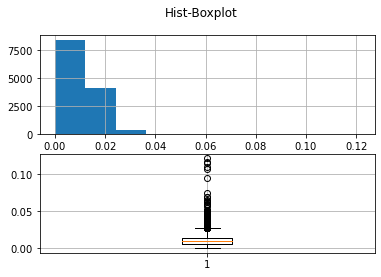

Column name: UCU
NANs: 0
Negatives: 0
Zeros: 131
Positives: 12833

0.00000    131
0.00526     27
0.00573     25
0.00860     24
0.01053     23
          ... 
0.03718      1
0.02332      1
0.02534      1
0.03289      1
0.00626      1
Name: UCU, Length: 3260, dtype: int64



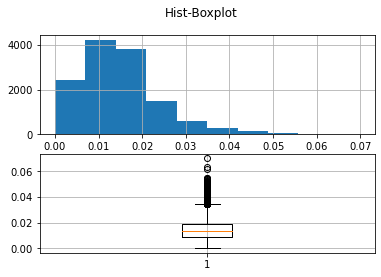

Column name: UCC
NANs: 0
Negatives: 0
Zeros: 101
Positives: 12863

0.00000    101
0.01972     36
0.00478     33
0.01579     22
0.01316     21
          ... 
0.02373      1
0.00669      1
0.03060      1
0.00296      1
0.02995      1
Name: UCC, Length: 2996, dtype: int64



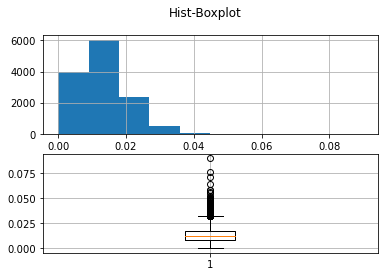

Column name: UCA
NANs: 0
Negatives: 0
Zeros: 103
Positives: 12861

0.00000    103
0.02761     39
0.02309     29
0.02105     22
0.01587     21
          ... 
0.04307      1
0.03622      1
0.03233      1
0.02077      1
0.02371      1
Name: UCA, Length: 3390, dtype: int64



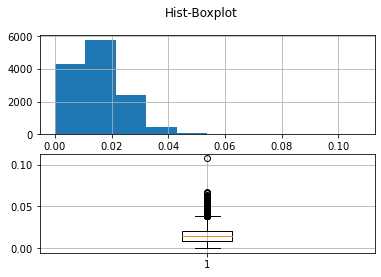

Column name: UCG
NANs: 0
Negatives: 0
Zeros: 808
Positives: 12156

0.00000    808
0.00287     42
0.00239     39
0.00263     36
0.01183     36
          ... 
0.01221      1
0.01761      1
0.02063      1
0.02178      1
0.00009      1
Name: UCG, Length: 2302, dtype: int64



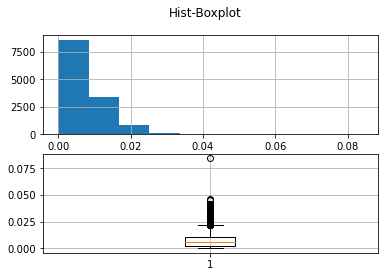

Column name: AGU
NANs: 0
Negatives: 0
Zeros: 591
Positives: 12373

0.00000    591
0.00263     70
0.01381     44
0.00336     33
0.00955     31
          ... 
0.02171      1
0.00017      1
0.02307      1
0.02856      1
0.02090      1
Name: AGU, Length: 2438, dtype: int64



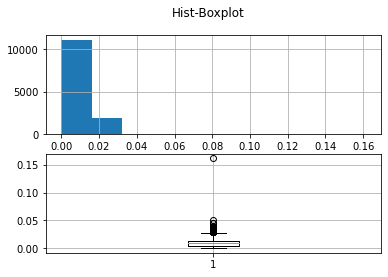

Column name: AGC
NANs: 0
Negatives: 0
Zeros: 193
Positives: 12771

0.00000    193
0.00262     52
0.00394     50
0.00789     45
0.00478     44
          ... 
0.00360      1
0.02006      1
0.00034      1
0.00062      1
0.01958      1
Name: AGC, Length: 2562, dtype: int64



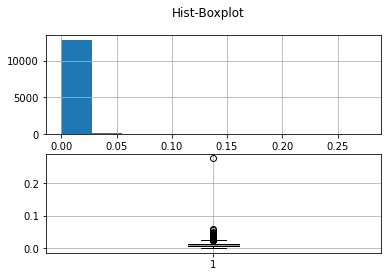

Column name: ACU
NANs: 0
Negatives: 0
Zeros: 70
Positives: 12894

0.00000    70
0.01183    43
0.03662    29
0.00789    25
0.01053    24
           ..
0.00682     1
0.00253     1
0.00552     1
0.03956     1
0.03280     1
Name: ACU, Length: 3250, dtype: int64



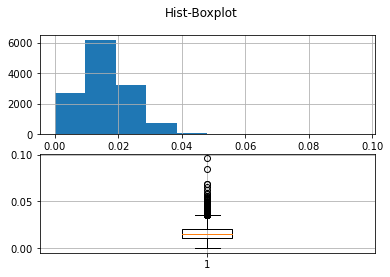

Column name: ACC
NANs: 0
Negatives: 0
Zeros: 70
Positives: 12894

0.00000    70
0.00197    47
0.00955    38
0.00196    30
0.00789    20
           ..
0.02867     1
0.03793     1
0.03387     1
0.03451     1
0.05031     1
Name: ACC, Length: 4183, dtype: int64



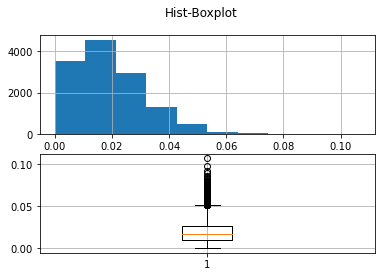

Column name: ACA
NANs: 0
Negatives: 0
Zeros: 100
Positives: 12864

0.00000    100
0.00197     43
0.02866     25
0.00196     22
0.01481     17
          ... 
0.04087      1
0.02128      1
0.00137      1
0.05570      1
0.03446      1
Name: ACA, Length: 4169, dtype: int64



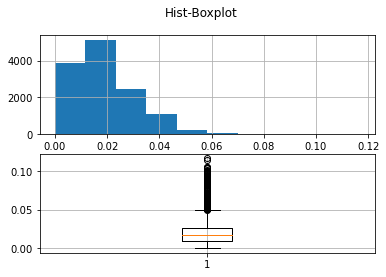

Column name: ACG
NANs: 0
Negatives: 0
Zeros: 645
Positives: 12319

0.00000    645
0.00394     58
0.00263     45
0.00318     43
0.00198     35
          ... 
0.03292      1
0.02592      1
0.02096      1
0.04086      1
0.00013      1
Name: ACG, Length: 2481, dtype: int64



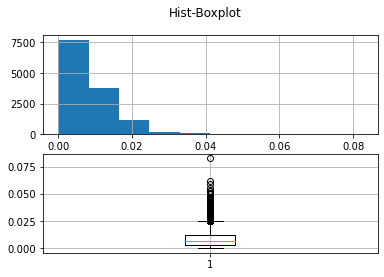

Column name: UAU
NANs: 0
Negatives: 0
Zeros: 122
Positives: 12842

0.00000    122
0.04536     31
0.00573     26
0.02787     25
0.00576     24
          ... 
0.05506      1
0.00323      1
0.05078      1
0.05183      1
0.00994      1
Name: UAU, Length: 3957, dtype: int64



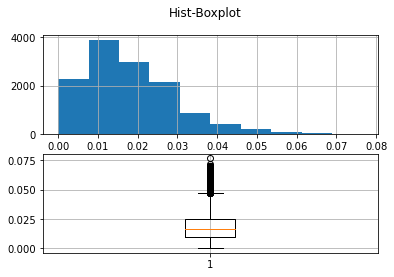

Column name: UAC
NANs: 0
Negatives: 0
Zeros: 36
Positives: 12928

0.01433    53
0.00986    44
0.00000    36
0.01441    27
0.01719    25
           ..
0.03075     1
0.00609     1
0.03974     1
0.00209     1
0.02223     1
Name: UAC, Length: 2999, dtype: int64



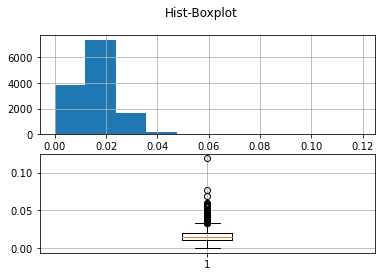

Column name: CAA
NANs: 0
Negatives: 0
Zeros: 54
Positives: 12910

0.01579    63
0.00000    54
0.02367    46
0.03503    36
0.01842    34
           ..
0.00070     1
0.04234     1
0.02965     1
0.00144     1
0.05165     1
Name: CAA, Length: 3669, dtype: int64



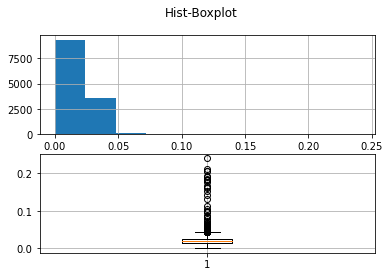

Column name: CAG
NANs: 0
Negatives: 0
Zeros: 451
Positives: 12513

0.00000    451
0.00789     46
0.00263     39
0.00262     36
0.00287     25
          ... 
0.00976      1
0.04032      1
0.02188      1
0.03706      1
0.03423      1
Name: CAG, Length: 3720, dtype: int64



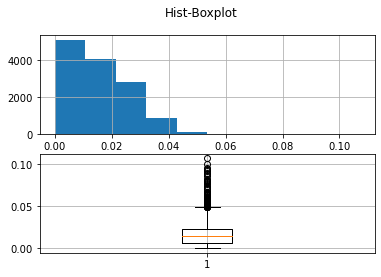

Column name: AAU
NANs: 0
Negatives: 0
Zeros: 60
Positives: 12904

0.00000    60
0.04536    38
0.04140    20
0.00860    20
0.01579    19
           ..
0.05406     1
0.00089     1
0.01471     1
0.02699     1
0.01351     1
Name: AAU, Length: 4648, dtype: int64



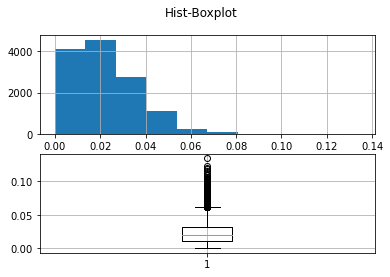

Column name: AAC
NANs: 0
Negatives: 0
Zeros: 24
Positives: 12940

0.00986    40
0.02229    35
0.00000    24
0.02632    20
0.01433    20
           ..
0.01430     1
0.04137     1
0.04220     1
0.05223     1
0.03683     1
Name: AAC, Length: 3667, dtype: int64



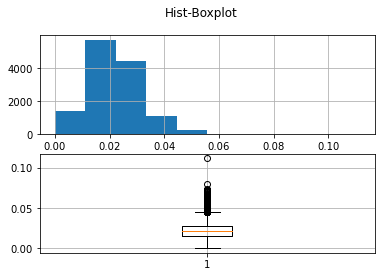

Column name: UGU
NANs: 0
Negatives: 0
Zeros: 839
Positives: 12125

0.00000    839
0.00263     76
0.00986     52
0.00336     32
0.00264     31
          ... 
0.03007      1
0.01820      1
0.02670      1
0.02251      1
0.01779      1
Name: UGU, Length: 2202, dtype: int64



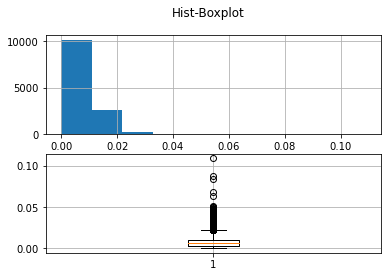

Column name: UGC
NANs: 0
Negatives: 0
Zeros: 503
Positives: 12461

0.00000    503
0.00287     59
0.00789     53
0.01053     50
0.00787     39
          ... 
0.01945      1
0.01289      1
0.01534      1
0.01595      1
0.02461      1
Name: UGC, Length: 2196, dtype: int64



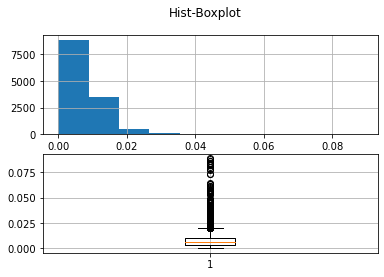

Column name: CAU
NANs: 0
Negatives: 0
Zeros: 147
Positives: 12817

0.00000    147
0.01035     43
0.00860     38
0.01053     35
0.01316     33
          ... 
0.01940      1
0.02734      1
0.00226      1
0.00158      1
0.02540      1
Name: CAU, Length: 2611, dtype: int64



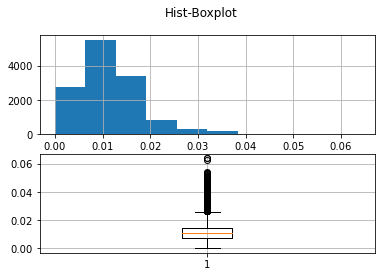

Column name: CAC
NANs: 0
Negatives: 0
Zeros: 86
Positives: 12878

0.00000    86
0.00789    47
0.00159    37
0.01433    23
0.00783    22
           ..
0.00222     1
0.02151     1
0.03054     1
0.00149     1
0.01802     1
Name: CAC, Length: 2667, dtype: int64



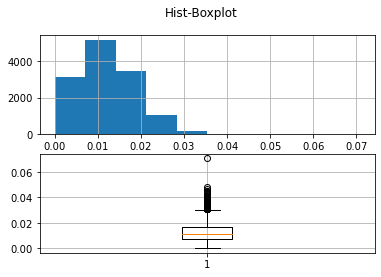

Column name: AAA
NANs: 0
Negatives: 0
Zeros: 57
Positives: 12907

0.00000    57
0.02368    41
0.02362    37
0.04339    35
0.02548    28
           ..
0.08838     1
0.05596     1
0.00531     1
0.00160     1
0.02359     1
Name: AAA, Length: 5272, dtype: int64



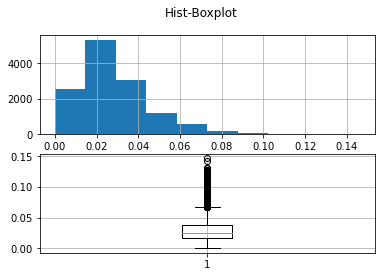

Column name: AAG
NANs: 0
Negatives: 0
Zeros: 405
Positives: 12559

0.00000    405
0.00263     65
0.01972     36
0.02070     32
0.00262     32
          ... 
0.07888      1
0.04640      1
0.04030      1
0.01189      1
0.04366      1
Name: AAG, Length: 4526, dtype: int64



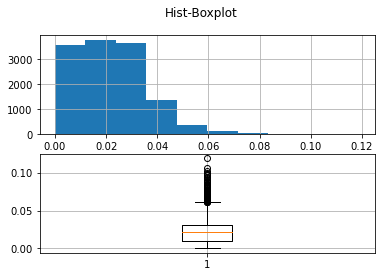

Column name: CGU
NANs: 0
Negatives: 0
Zeros: 578
Positives: 12386

0.00000    578
0.00263     86
0.00287     68
0.00557     43
0.00262     36
          ... 
0.01312      1
0.02060      1
0.02120      1
0.02118      1
0.00039      1
Name: CGU, Length: 2294, dtype: int64



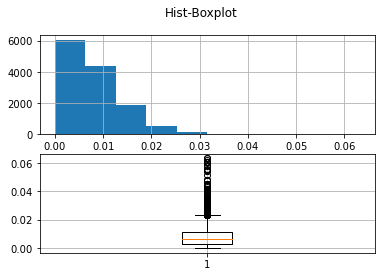

Column name: CGC
NANs: 0
Negatives: 0
Zeros: 500
Positives: 12464

0.00000    500
0.00526     72
0.00263     54
0.00592     53
0.00288     48
          ... 
0.02901      1
0.03636      1
0.01854      1
0.02633      1
0.02094      1
Name: CGC, Length: 3171, dtype: int64



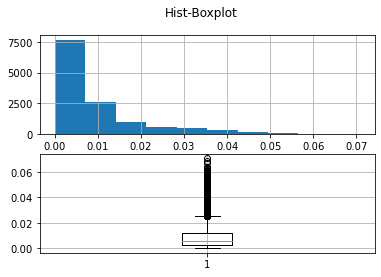

Column name: CGA
NANs: 0
Negatives: 0
Zeros: 337
Positives: 12627

0.00000    337
0.01316     49
0.01579     49
0.00318     43
0.00576     38
          ... 
0.02170      1
0.01881      1
0.02150      1
0.03326      1
0.01248      1
Name: CGA, Length: 1880, dtype: int64



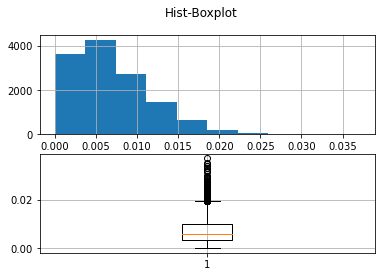

Column name: CGG
NANs: 0
Negatives: 0
Zeros: 1390
Positives: 11574

0.00000    1390
0.00394      57
0.00263      43
0.00159      43
0.00057      38
           ... 
0.03218       1
0.03780       1
0.03300       1
0.02376       1
0.01037       1
Name: CGG, Length: 2129, dtype: int64



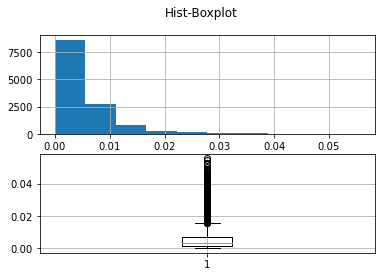

Column name: AGA
NANs: 0
Negatives: 0
Zeros: 1772
Positives: 11192

0.00000    1772
0.00263     161
0.02170      37
0.00034      31
0.00264      28
           ... 
0.02709       1
0.02988       1
0.00491       1
0.03087       1
0.00846       1
Name: AGA, Length: 2832, dtype: int64



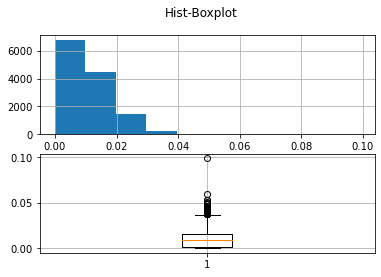

Column name: AGG
NANs: 0
Negatives: 0
Zeros: 2226
Positives: 10738

0.00000    2226
0.00986      43
0.00391      37
0.00056      36
0.01035      33
           ... 
0.01745       1
0.01993       1
0.02074       1
0.01471       1
0.01333       1
Name: AGG, Length: 2228, dtype: int64



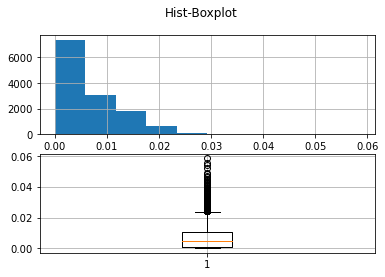

Column name: GAU
NANs: 0
Negatives: 0
Zeros: 261
Positives: 12703

0.00000    261
0.02367     41
0.03901     31
0.00526     29
0.00789     28
          ... 
0.04857      1
0.04090      1
0.04342      1
0.02979      1
0.00451      1
Name: GAU, Length: 4575, dtype: int64



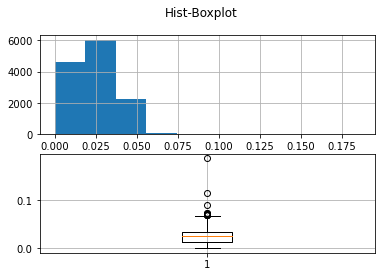

Column name: GAC
NANs: 0
Negatives: 0
Zeros: 112
Positives: 12852

0.00000    112
0.00789     45
0.00287     37
0.01842     32
0.01911     29
          ... 
0.05236      1
0.05409      1
0.00694      1
0.04125      1
0.03401      1
Name: GAC, Length: 4409, dtype: int64



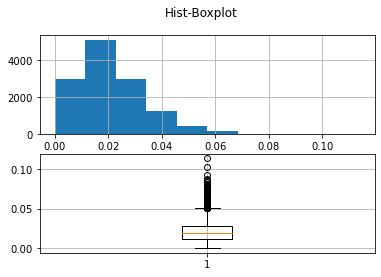

Column name: GAA
NANs: 0
Negatives: 0
Zeros: 16
Positives: 12948

0.01316    55
0.01579    52
0.01433    41
0.03353    35
0.01837    27
           ..
0.06695     1
0.04064     1
0.04195     1
0.04562     1
0.00744     1
Name: GAA, Length: 4818, dtype: int64



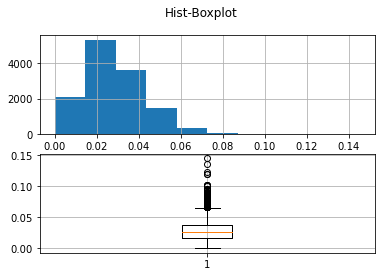

Column name: GAG
NANs: 0
Negatives: 0
Zeros: 438
Positives: 12526

0.00000    438
0.00263     45
0.01381     36
0.01672     33
0.00287     20
          ... 
0.00832      1
0.01108      1
0.08218      1
0.04134      1
0.03689      1
Name: GAG, Length: 4675, dtype: int64



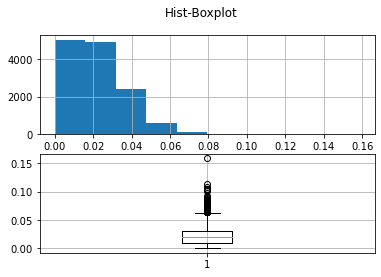

Column name: UAA
NANs: 0
Negatives: 0
Zeros: 1806
Positives: 11158

0.00000    1806
0.00046     122
0.00287      97
0.00262      92
0.00080      83
           ... 
0.02438       1
0.01500       1
0.00519       1
0.00413       1
0.00860       1
Name: UAA, Length: 703, dtype: int64



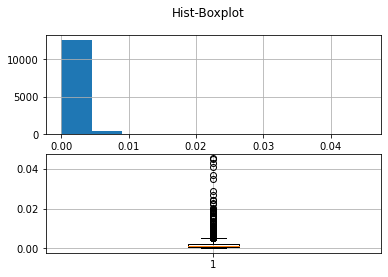

Column name: UAG
NANs: 0
Negatives: 0
Zeros: 4298
Positives: 8666

0.00000    4298
0.00090     123
0.00056     119
0.00044     112
0.00047     110
           ... 
0.00410       1
0.01142       1
0.00696       1
0.00453       1
0.00321       1
Name: UAG, Length: 422, dtype: int64



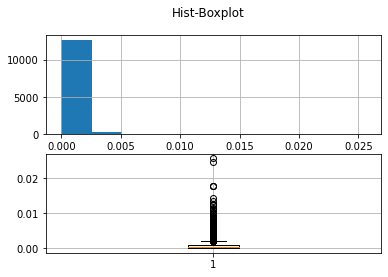

Column name: UGA
NANs: 0
Negatives: 0
Zeros: 2121
Positives: 10843

0.00000    2121
0.00197      98
0.00090      80
0.00196      71
0.00091      70
           ... 
0.00363       1
0.00360       1
0.02133       1
0.08603       1
0.00638       1
Name: UGA, Length: 1782, dtype: int64



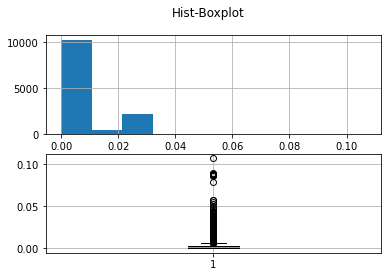

In [ ]:
print(df.shape)
preview_dataset(df)

In [ ]:
df.dropna(inplace=True)

(12962, 67)
Column name: Kingdom
NANs: 0
Negatives: 0
Zeros: 126
Positives: 12836

1     2917
9     2831
6     2490
10    2077
2     1334
3      572
4      220
8      215
7      180
0      126
Name: Kingdom, dtype: int64



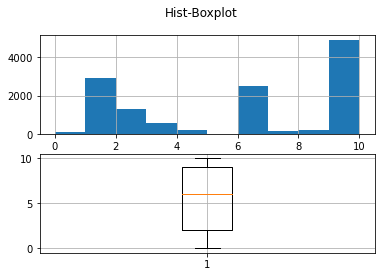

Column name: DNAtype
NANs: 0
Negatives: 0
Zeros: 9247
Positives: 3715

0    9247
1    2899
2     816
Name: DNAtype, dtype: int64



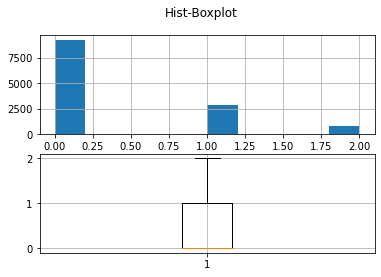

Column name: Ncodons
NANs: 0
Negatives: 0
Zeros: 0
Positives: 12962

1140       67
1784       58
1054       44
1047       39
1014       39
           ..
38314       1
1774174     1
17263       1
3825        1
8998998     1
Name: Ncodons, Length: 7083, dtype: int64



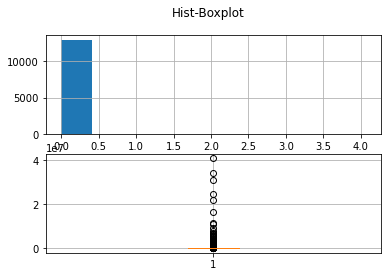

Column name: UUU
NANs: 0
Negatives: 0
Zeros: 81
Positives: 12881

0.00000    81
0.04536    34
0.04618    28
0.01423    17
0.01761    17
           ..
0.04725     1
0.05056     1
0.00728     1
0.03351     1
0.00554     1
Name: UUU, Length: 4762, dtype: int64



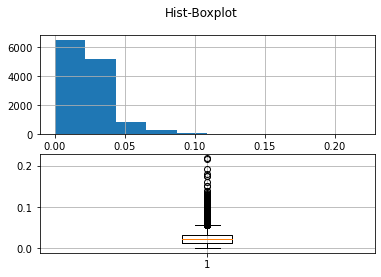

Column name: UUC
NANs: 0
Negatives: 0
Zeros: 16
Positives: 12946

0.01911    43
0.02564    42
0.01433    19
0.01134    19
0.01190    18
           ..
0.03637     1
0.00326     1
0.04537     1
0.02752     1
0.03555     1
Name: UUC, Length: 4112, dtype: int64



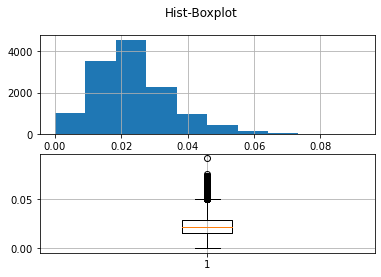

Column name: UUA
NANs: 0
Negatives: 0
Zeros: 459
Positives: 12503

0.00000    459
0.01513     41
0.03748     32
0.00093     17
0.01682     15
          ... 
0.01877      1
0.06587      1
0.04537      1
0.12693      1
0.04059      1
Name: UUA, Length: 4776, dtype: int64



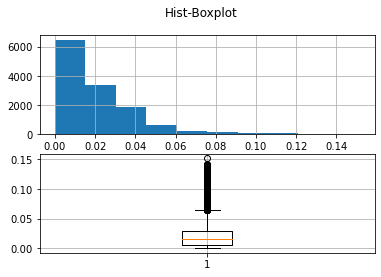

Column name: UUG
NANs: 0
Negatives: 0
Zeros: 450
Positives: 12512

0.00000    450
0.00263     47
0.01035     42
0.03156     34
0.01774     22
          ... 
0.03343      1
0.03488      1
0.00062      1
0.02755      1
0.00619      1
Name: UUG, Length: 3269, dtype: int64



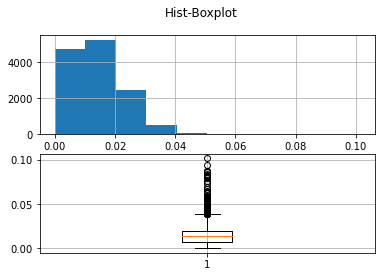

Column name: CUU
NANs: 0
Negatives: 0
Zeros: 35
Positives: 12927

0.02564    43
0.00000    35
0.02627    35
0.01312    22
0.00945    19
           ..
0.03658     1
0.02121     1
0.03337     1
0.00913     1
0.03415     1
Name: CUU, Length: 3675, dtype: int64



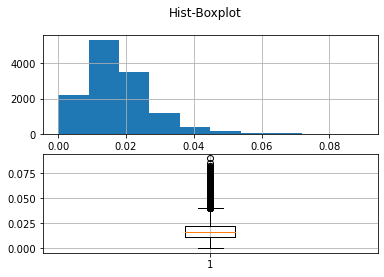

Column name: CUC
NANs: 0
Negatives: 0
Zeros: 234
Positives: 12728

0.00000    234
0.00789     40
0.01513     38
0.00587     20
0.00794     20
          ... 
0.04569      1
0.02333      1
0.01157      1
0.05463      1
0.05042      1
Name: CUC, Length: 4387, dtype: int64



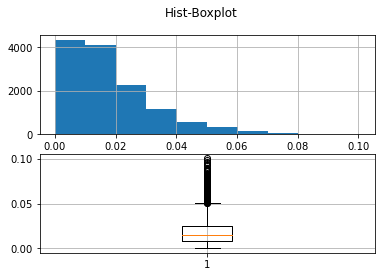

Column name: CUA
NANs: 0
Negatives: 0
Zeros: 275
Positives: 12687

0.00000    275
0.00796     39
0.01775     31
0.01389     24
0.01039     22
          ... 
0.04199      1
0.04736      1
0.04045      1
0.03528      1
0.07604      1
Name: CUA, Length: 4058, dtype: int64



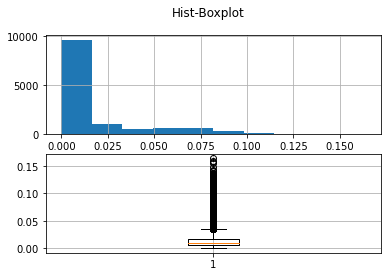

Column name: CUG
NANs: 0
Negatives: 0
Zeros: 220
Positives: 12742

0.00000    220
0.00789     56
0.00318     43
0.00263     30
0.00975     25
          ... 
0.03853      1
0.05455      1
0.06188      1
0.03148      1
0.03555      1
Name: CUG, Length: 4555, dtype: int64



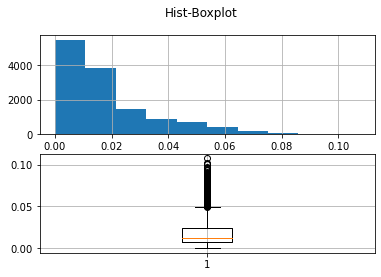

Column name: AUU
NANs: 0
Negatives: 0
Zeros: 51
Positives: 12911

0.00000    51
0.04734    38
0.04220    28
0.02170    15
0.02092    13
           ..
0.05244     1
0.00486     1
0.00346     1
0.00461     1
0.02772     1
Name: AUU, Length: 5228, dtype: int64



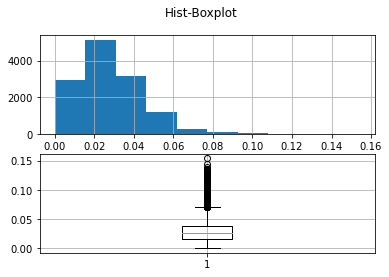

Column name: AUC
NANs: 0
Negatives: 0
Zeros: 15
Positives: 12947

0.00986    47
0.00796    29
0.01124    17
0.00992    17
0.01701    16
           ..
0.01373     1
0.03579     1
0.03399     1
0.00906     1
0.05137     1
Name: AUC, Length: 4679, dtype: int64



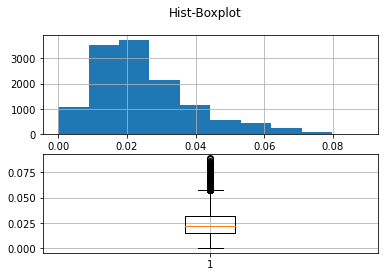

Column name: AUA
NANs: 0
Negatives: 0
Zeros: 289
Positives: 12673

0.00000    289
0.01775     40
0.01115     39
0.02579     29
0.02362     18
          ... 
0.05589      1
0.04424      1
0.02256      1
0.04753      1
0.03435      1
Name: AUA, Length: 4467, dtype: int64



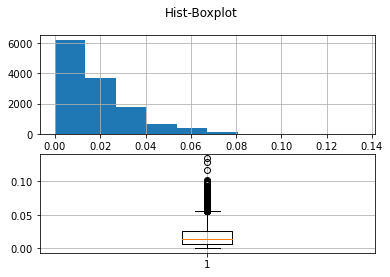

Column name: AUG
NANs: 0
Negatives: 0
Zeros: 13
Positives: 12949

0.00263    46
0.01775    38
0.00789    36
0.01592    35
0.00526    27
           ..
0.03552     1
0.01220     1
0.03785     1
0.04214     1
0.00582     1
Name: AUG, Length: 3231, dtype: int64



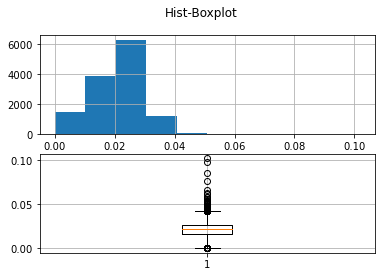

Column name: GUU
NANs: 0
Negatives: 0
Zeros: 106
Positives: 12856

0.00000    106
0.01183     43
0.03901     26
0.00860     25
0.00288     24
          ... 
0.03443      1
0.03257      1
0.00238      1
0.03600      1
0.00629      1
Name: GUU, Length: 3635, dtype: int64



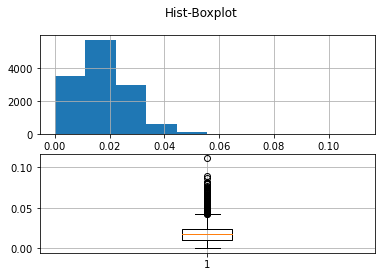

Column name: GUC
NANs: 0
Negatives: 0
Zeros: 90
Positives: 12872

0.00000    90
0.00592    50
0.01513    49
0.01316    29
0.00573    22
           ..
0.05258     1
0.04818     1
0.03954     1
0.03563     1
0.00498     1
Name: GUC, Length: 3599, dtype: int64



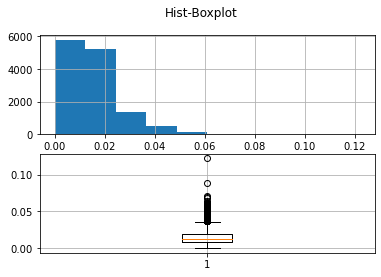

Column name: GUA
NANs: 0
Negatives: 0
Zeros: 111
Positives: 12851

0.00000    111
0.01775     44
0.00955     40
0.00287     26
0.00573     22
          ... 
0.03025      1
0.03952      1
0.02827      1
0.02954      1
0.03358      1
Name: GUA, Length: 3148, dtype: int64



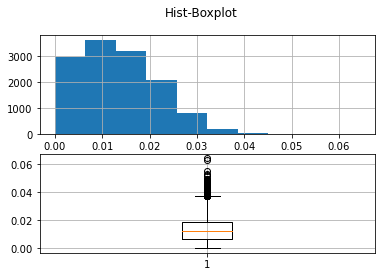

Column name: GUG
NANs: 0
Negatives: 0
Zeros: 416
Positives: 12546

0.00000    416
0.00263     54
0.00592     45
0.01035     36
0.00262     25
          ... 
0.03010      1
0.02418      1
0.02491      1
0.03837      1
0.04154      1
Name: GUG, Length: 3989, dtype: int64



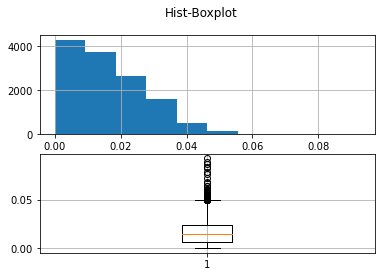

Column name: GCU
NANs: 0
Negatives: 0
Zeros: 21
Positives: 12941

0.01972    36
0.03742    27
0.01316    23
0.01053    22
0.00789    21
           ..
0.04142     1
0.00475     1
0.00604     1
0.00684     1
0.01109     1
Name: GCU, Length: 3715, dtype: int64



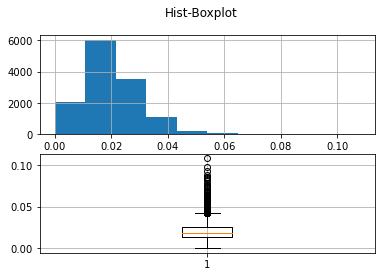

Column name: GCC
NANs: 0
Negatives: 0
Zeros: 85
Positives: 12877

0.00000    85
0.00789    43
0.00955    37
0.02105    25
0.00978    21
           ..
0.05192     1
0.09092     1
0.04560     1
0.04456     1
0.03821     1
Name: GCC, Length: 5032, dtype: int64



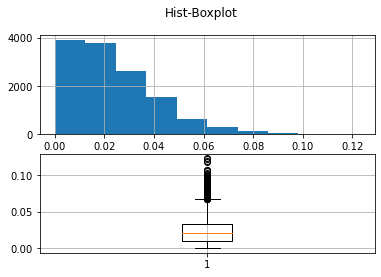

Column name: GCA
NANs: 0
Negatives: 0
Zeros: 25
Positives: 12937

0.00789    41
0.01354    32
0.00000    25
0.02632    24
0.02292    22
           ..
0.01241     1
0.00801     1
0.00179     1
0.00473     1
0.00576     1
Name: GCA, Length: 3446, dtype: int64



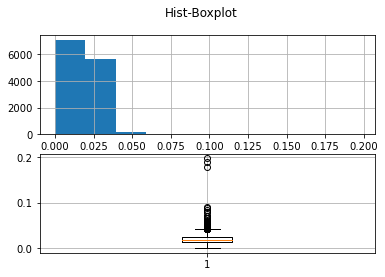

Column name: GCG
NANs: 0
Negatives: 0
Zeros: 819
Positives: 12143

0.00000    819
0.00197     73
0.00398     45
0.00196     42
0.00198     37
          ... 
0.03905      1
0.04885      1
0.04876      1
0.01820      1
0.01990      1
Name: GCG, Length: 3550, dtype: int64



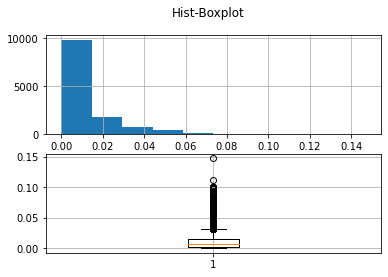

Column name: CCU
NANs: 0
Negatives: 0
Zeros: 53
Positives: 12909

0.00000    53
0.01183    33
0.02707    29
0.00984    25
0.01050    24
           ..
0.00157     1
0.02818     1
0.06183     1
0.00138     1
0.02931     1
Name: CCU, Length: 2750, dtype: int64



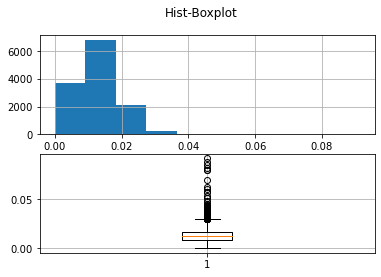

Column name: CCC
NANs: 0
Negatives: 0
Zeros: 202
Positives: 12760

0.00000    202
0.00239     43
0.00787     28
0.01316     23
0.01053     22
          ... 
0.03019      1
0.02700      1
0.03733      1
0.04898      1
0.01979      1
Name: CCC, Length: 3221, dtype: int64



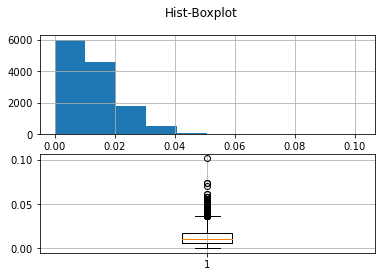

Column name: CCA
NANs: 0
Negatives: 0
Zeros: 69
Positives: 12893

0.00000    69
0.01381    47
0.01513    43
0.00860    35
0.01389    22
           ..
0.00202     1
0.03110     1
0.02821     1
0.03411     1
0.03191     1
Name: CCA, Length: 3488, dtype: int64



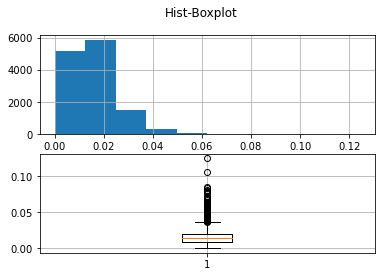

Column name: CCG
NANs: 0
Negatives: 0
Zeros: 747
Positives: 12215

0.00000    747
0.00263     53
0.00159     52
0.00394     36
0.00196     33
          ... 
0.01463      1
0.02502      1
0.03501      1
0.02220      1
0.01332      1
Name: CCG, Length: 2884, dtype: int64



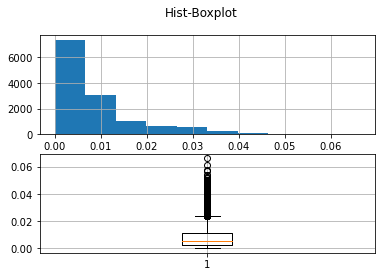

Column name: UGG
NANs: 0
Negatives: 0
Zeros: 405
Positives: 12557

0.00000    405
0.01578     46
0.00876     44
0.00263     44
0.01389     28
          ... 
0.02029      1
0.02431      1
0.00492      1
0.02309      1
0.00433      1
Name: UGG, Length: 2596, dtype: int64



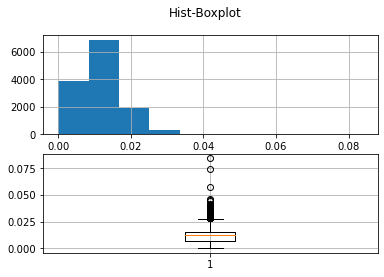

Column name: GGU
NANs: 0
Negatives: 0
Zeros: 134
Positives: 12828

0.00000    134
0.00789     67
0.02468     35
0.00526     30
0.00787     23
          ... 
0.03432      1
0.04107      1
0.03338      1
0.00325      1
0.00237      1
Name: GGU, Length: 3616, dtype: int64



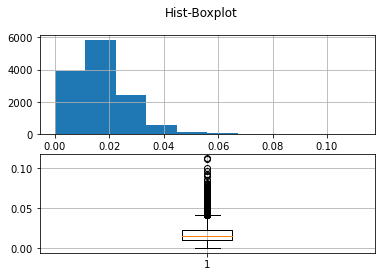

Column name: GGC
NANs: 0
Negatives: 0
Zeros: 175
Positives: 12787

0.00000    175
0.00592     38
0.00197     36
0.00198     29
0.01911     28
          ... 
0.03764      1
0.05408      1
0.05141      1
0.02475      1
0.02163      1
Name: GGC, Length: 4382, dtype: int64



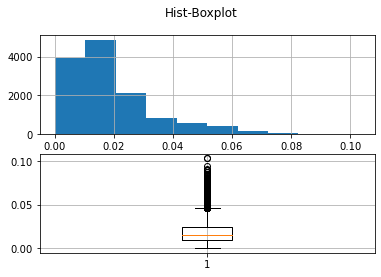

Column name: GGA
NANs: 0
Negatives: 0
Zeros: 34
Positives: 12928

0.01592    48
0.01183    42
0.00000    34
0.01992    20
0.02092    19
           ..
0.03641     1
0.03300     1
0.03009     1
0.04386     1
0.00503     1
Name: GGA, Length: 3538, dtype: int64



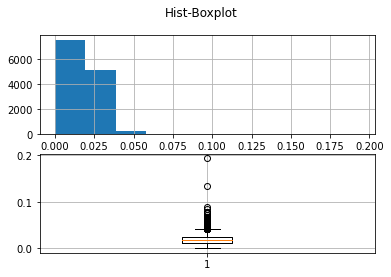

Column name: GGG
NANs: 0
Negatives: 0
Zeros: 199
Positives: 12763

0.00000    199
0.01183     42
0.00263     41
0.00318     39
0.00789     35
          ... 
0.04010      1
0.03444      1
0.02668      1
0.03329      1
0.02129      1
Name: GGG, Length: 2611, dtype: int64



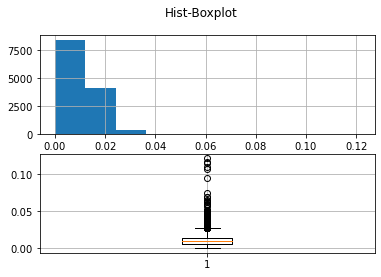

Column name: UCU
NANs: 0
Negatives: 0
Zeros: 131
Positives: 12831

0.00000    131
0.00526     27
0.00573     25
0.00860     24
0.01053     23
          ... 
0.02551      1
0.04086      1
0.04180      1
0.03846      1
0.00626      1
Name: UCU, Length: 3260, dtype: int64



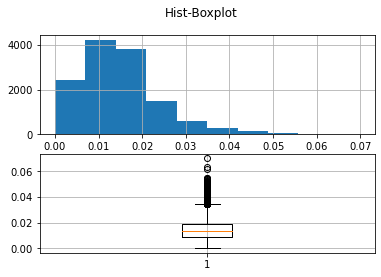

Column name: UCC
NANs: 0
Negatives: 0
Zeros: 101
Positives: 12861

0.00000    101
0.01972     36
0.00478     33
0.01579     22
0.01316     21
          ... 
0.00358      1
0.00045      1
0.03085      1
0.03052      1
0.02995      1
Name: UCC, Length: 2995, dtype: int64



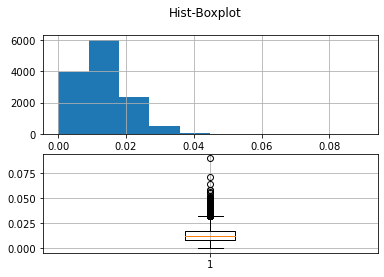

Column name: UCA
NANs: 0
Negatives: 0
Zeros: 103
Positives: 12859

0.00000    103
0.02761     39
0.02309     29
0.02105     22
0.01587     21
          ... 
0.04307      1
0.03622      1
0.03233      1
0.02077      1
0.02371      1
Name: UCA, Length: 3390, dtype: int64



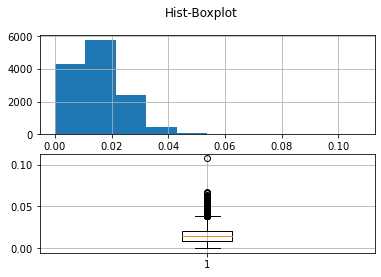

Column name: UCG
NANs: 0
Negatives: 0
Zeros: 808
Positives: 12154

0.00000    808
0.00287     42
0.00239     39
0.00263     36
0.01183     36
          ... 
0.01221      1
0.01761      1
0.02063      1
0.02178      1
0.00009      1
Name: UCG, Length: 2302, dtype: int64



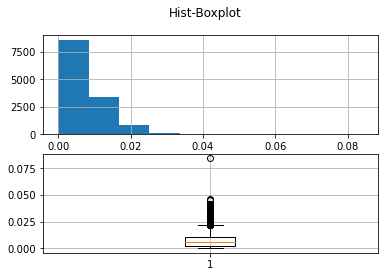

Column name: AGU
NANs: 0
Negatives: 0
Zeros: 591
Positives: 12371

0.00000    591
0.00263     70
0.01381     44
0.00336     33
0.00955     31
          ... 
0.02536      1
0.01787      1
0.02668      1
0.02230      1
0.02090      1
Name: AGU, Length: 2438, dtype: int64



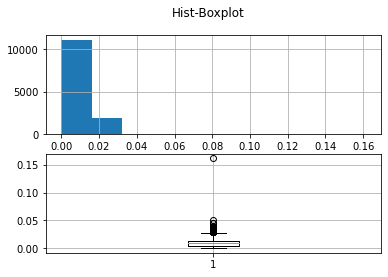

Column name: AGC
NANs: 0
Negatives: 0
Zeros: 193
Positives: 12769

0.00000    193
0.00262     52
0.00394     50
0.00789     45
0.00478     44
          ... 
0.01405      1
0.00360      1
0.02006      1
0.00034      1
0.01958      1
Name: AGC, Length: 2562, dtype: int64



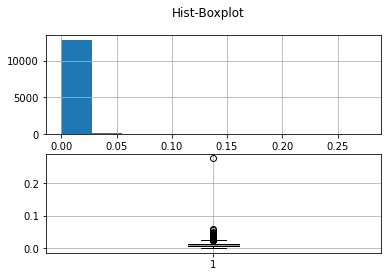

Column name: ACU
NANs: 0
Negatives: 0
Zeros: 70
Positives: 12892

0.00000    70
0.01183    43
0.03662    29
0.00789    25
0.01053    24
           ..
0.00433     1
0.00209     1
0.02945     1
0.00920     1
0.03280     1
Name: ACU, Length: 3250, dtype: int64



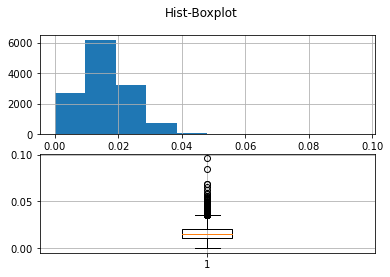

Column name: ACC
NANs: 0
Negatives: 0
Zeros: 70
Positives: 12892

0.00000    70
0.00197    47
0.00955    38
0.00196    30
0.00789    20
           ..
0.04922     1
0.05946     1
0.04479     1
0.00553     1
0.05031     1
Name: ACC, Length: 4183, dtype: int64



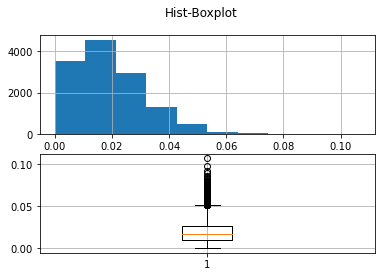

Column name: ACA
NANs: 0
Negatives: 0
Zeros: 100
Positives: 12862

0.00000    100
0.00197     43
0.02866     25
0.00196     22
0.01481     17
          ... 
0.04087      1
0.02128      1
0.00137      1
0.05570      1
0.03446      1
Name: ACA, Length: 4169, dtype: int64



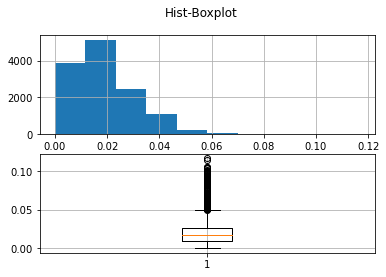

Column name: ACG
NANs: 0
Negatives: 0
Zeros: 645
Positives: 12317

0.00000    645
0.00394     58
0.00263     45
0.00318     43
0.00198     35
          ... 
0.03292      1
0.02592      1
0.02096      1
0.04086      1
0.00013      1
Name: ACG, Length: 2481, dtype: int64



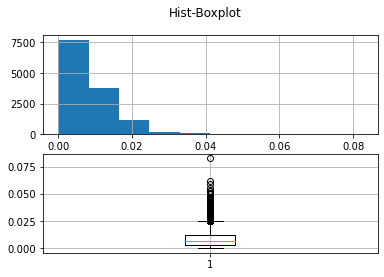

Column name: UAU
NANs: 0
Negatives: 0
Zeros: 122
Positives: 12840

0.00000    122
0.04536     31
0.00573     26
0.02787     25
0.00576     24
          ... 
0.03764      1
0.03279      1
0.00384      1
0.02364      1
0.00994      1
Name: UAU, Length: 3957, dtype: int64



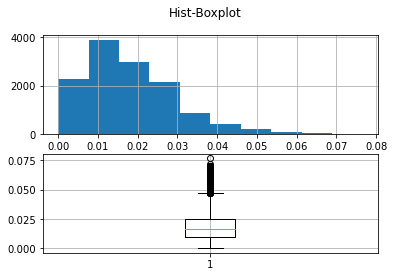

Column name: UAC
NANs: 0
Negatives: 0
Zeros: 36
Positives: 12926

0.01433    53
0.00986    44
0.00000    36
0.01441    27
0.01719    25
           ..
0.03075     1
0.00609     1
0.03974     1
0.00209     1
0.02223     1
Name: UAC, Length: 2998, dtype: int64



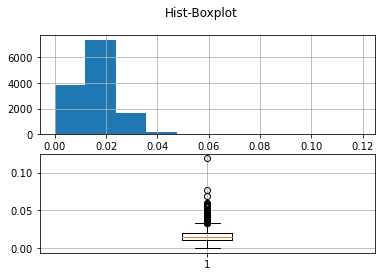

Column name: CAA
NANs: 0
Negatives: 0
Zeros: 54
Positives: 12908

0.01579    63
0.00000    54
0.02367    46
0.03503    36
0.01842    34
           ..
0.00070     1
0.04234     1
0.02965     1
0.00144     1
0.05165     1
Name: CAA, Length: 3669, dtype: int64



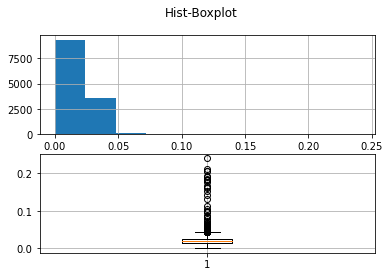

Column name: CAG
NANs: 0
Negatives: 0
Zeros: 451
Positives: 12511

0.00000    451
0.00789     46
0.00263     39
0.00262     36
0.00287     25
          ... 
0.00976      1
0.04032      1
0.02188      1
0.03706      1
0.03423      1
Name: CAG, Length: 3720, dtype: int64



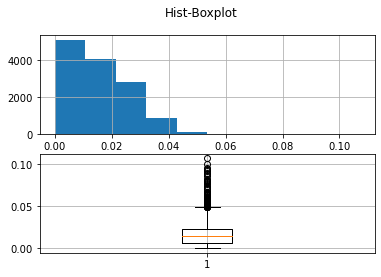

Column name: AAU
NANs: 0
Negatives: 0
Zeros: 60
Positives: 12902

0.00000    60
0.04536    38
0.00860    20
0.04140    20
0.00789    19
           ..
0.04368     1
0.06448     1
0.02680     1
0.03661     1
0.01351     1
Name: AAU, Length: 4648, dtype: int64



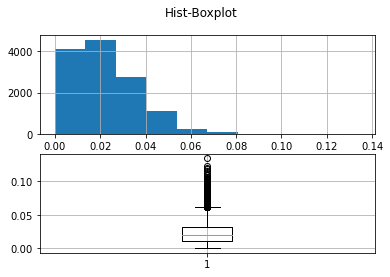

Column name: AAC
NANs: 0
Negatives: 0
Zeros: 24
Positives: 12938

0.00986    40
0.02229    35
0.00000    24
0.02632    20
0.01433    20
           ..
0.03261     1
0.01430     1
0.04137     1
0.04220     1
0.03683     1
Name: AAC, Length: 3667, dtype: int64



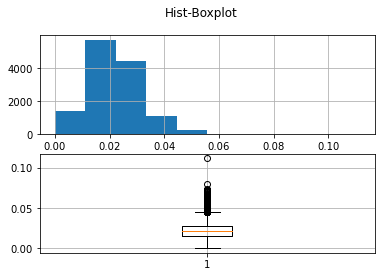

Column name: UGU
NANs: 0
Negatives: 0
Zeros: 839
Positives: 12123

0.00000    839
0.00263     76
0.00986     52
0.00336     32
0.00264     31
          ... 
0.01453      1
0.01573      1
0.01254      1
0.03211      1
0.01779      1
Name: UGU, Length: 2202, dtype: int64



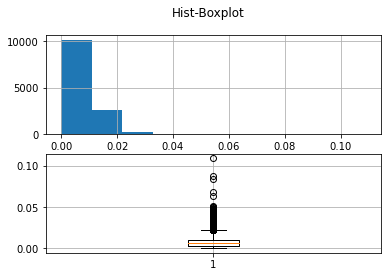

Column name: UGC
NANs: 0
Negatives: 0
Zeros: 503
Positives: 12459

0.00000    503
0.00287     59
0.00789     53
0.01053     50
0.00787     39
          ... 
0.06376      1
0.02261      1
0.04453      1
0.02366      1
0.02461      1
Name: UGC, Length: 2195, dtype: int64



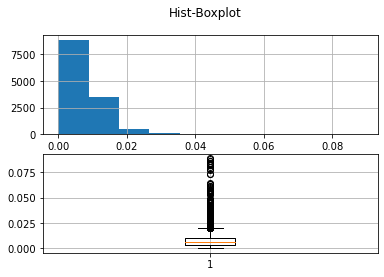

Column name: CAU
NANs: 0
Negatives: 0
Zeros: 147
Positives: 12815

0.00000    147
0.01035     43
0.00860     38
0.01053     35
0.01316     33
          ... 
0.01940      1
0.02734      1
0.00226      1
0.00158      1
0.02540      1
Name: CAU, Length: 2611, dtype: int64



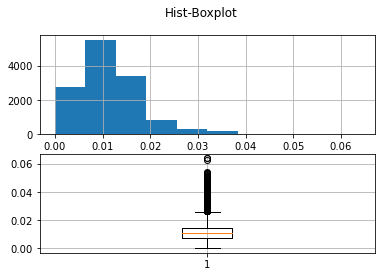

Column name: CAC
NANs: 0
Negatives: 0
Zeros: 86
Positives: 12876

0.00000    86
0.00789    47
0.00159    37
0.01433    23
0.00783    22
           ..
0.00222     1
0.02151     1
0.03054     1
0.00149     1
0.01802     1
Name: CAC, Length: 2667, dtype: int64



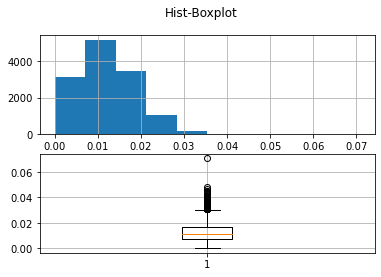

Column name: AAA
NANs: 0
Negatives: 0
Zeros: 57
Positives: 12905

0.00000    57
0.02368    41
0.02362    37
0.04339    35
0.02632    28
           ..
0.05596     1
0.00531     1
0.00160     1
0.07862     1
0.02359     1
Name: AAA, Length: 5272, dtype: int64



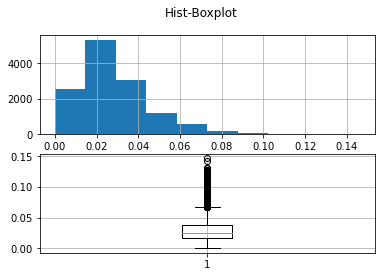

Column name: AAG
NANs: 0
Negatives: 0
Zeros: 405
Positives: 12557

0.00000    405
0.00263     65
0.01972     36
0.02070     32
0.00262     32
          ... 
0.07888      1
0.04640      1
0.04030      1
0.01189      1
0.04366      1
Name: AAG, Length: 4526, dtype: int64



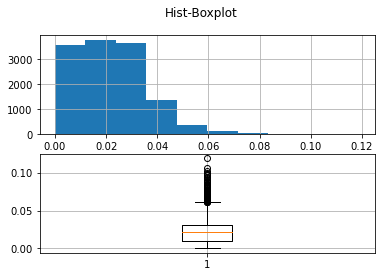

Column name: CGU
NANs: 0
Negatives: 0
Zeros: 578
Positives: 12384

0.00000    578
0.00263     86
0.00287     68
0.00557     43
0.00262     36
          ... 
0.02435      1
0.02241      1
0.02281      1
0.01739      1
0.00039      1
Name: CGU, Length: 2293, dtype: int64



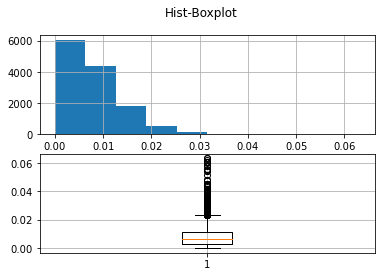

Column name: CGC
NANs: 0
Negatives: 0
Zeros: 500
Positives: 12462

0.00000    500
0.00526     72
0.00263     54
0.00592     53
0.00288     48
          ... 
0.05390      1
0.03538      1
0.02721      1
0.02843      1
0.02094      1
Name: CGC, Length: 3170, dtype: int64



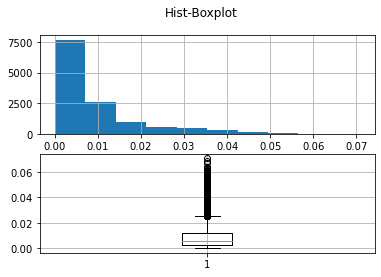

Column name: CGA
NANs: 0
Negatives: 0
Zeros: 337
Positives: 12625

0.00000    337
0.01316     49
0.01579     49
0.00318     43
0.00319     38
          ... 
0.01925      1
0.02959      1
0.01486      1
0.01727      1
0.01248      1
Name: CGA, Length: 1879, dtype: int64



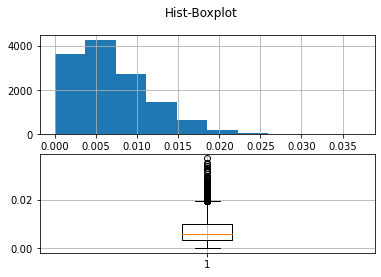

Column name: CGG
NANs: 0
Negatives: 0
Zeros: 1390
Positives: 11572

0.00000    1390
0.00394      57
0.00263      43
0.00159      43
0.00057      38
           ... 
0.01868       1
0.03218       1
0.03780       1
0.03300       1
0.01037       1
Name: CGG, Length: 2128, dtype: int64



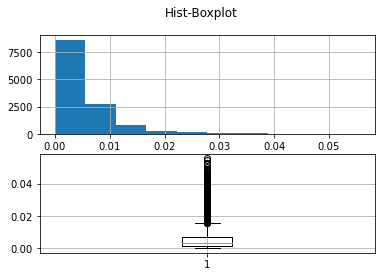

Column name: AGA
NANs: 0
Negatives: 0
Zeros: 1772
Positives: 11190

0.00000    1772
0.00263     161
0.02170      37
0.00034      31
0.00264      28
           ... 
0.03175       1
0.02922       1
0.02929       1
0.03130       1
0.00846       1
Name: AGA, Length: 2832, dtype: int64



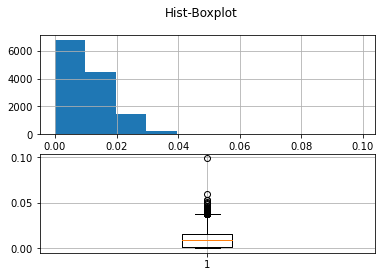

Column name: AGG
NANs: 0
Negatives: 0
Zeros: 2226
Positives: 10736

0.00000    2226
0.00986      43
0.00391      37
0.00056      36
0.01035      33
           ... 
0.02523       1
0.01745       1
0.01993       1
0.02074       1
0.01333       1
Name: AGG, Length: 2228, dtype: int64



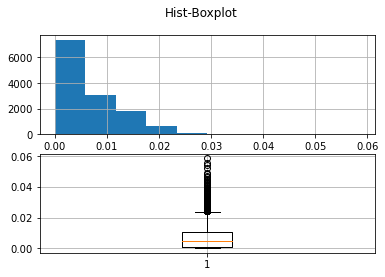

Column name: GAU
NANs: 0
Negatives: 0
Zeros: 261
Positives: 12701

0.00000    261
0.02367     41
0.03901     31
0.00526     29
0.00789     28
          ... 
0.04796      1
0.04416      1
0.04612      1
0.04658      1
0.00451      1
Name: GAU, Length: 4574, dtype: int64



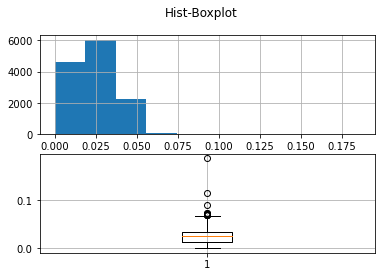

Column name: GAC
NANs: 0
Negatives: 0
Zeros: 111
Positives: 12851

0.00000    111
0.00789     45
0.00287     37
0.01842     32
0.01911     29
          ... 
0.04512      1
0.04481      1
0.00222      1
0.05773      1
0.03401      1
Name: GAC, Length: 4409, dtype: int64



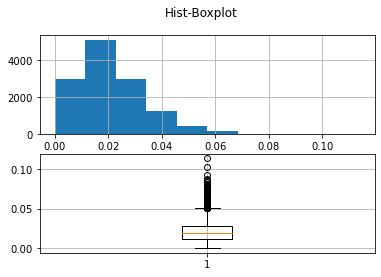

Column name: GAA
NANs: 0
Negatives: 0
Zeros: 16
Positives: 12946

0.01316    55
0.01579    52
0.01433    41
0.03353    35
0.01837    27
           ..
0.06695     1
0.04064     1
0.04195     1
0.04562     1
0.00744     1
Name: GAA, Length: 4818, dtype: int64



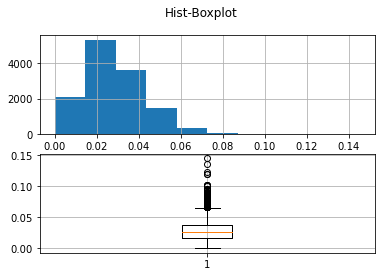

Column name: GAG
NANs: 0
Negatives: 0
Zeros: 438
Positives: 12524

0.00000    438
0.00263     45
0.01381     36
0.01672     33
0.00287     20
          ... 
0.01108      1
0.08218      1
0.03245      1
0.04134      1
0.03689      1
Name: GAG, Length: 4675, dtype: int64



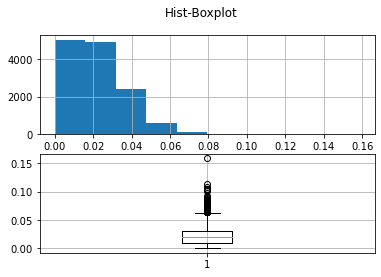

Column name: UAA
NANs: 0
Negatives: 0
Zeros: 1806
Positives: 11156

0.00000    1806
0.00046     122
0.00287      97
0.00262      92
0.00080      83
           ... 
0.00645       1
0.02411       1
0.00332       1
0.03484       1
0.00860       1
Name: UAA, Length: 701, dtype: int64



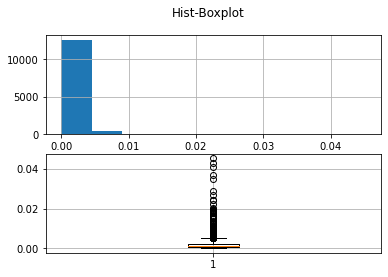

Column name: UAG
NANs: 0
Negatives: 0
Zeros: 4298
Positives: 8664

0.00000    4298
0.00090     123
0.00056     119
0.00044     112
0.00047     110
           ... 
0.00831       1
0.00357       1
0.00407       1
0.00347       1
0.00321       1
Name: UAG, Length: 421, dtype: int64



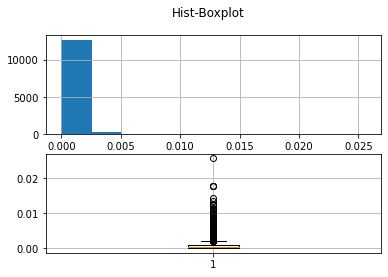

Column name: UGA
NANs: 0
Negatives: 0
Zeros: 2120
Positives: 10842

0.00000    2120
0.00197      98
0.00090      80
0.00196      71
0.00091      70
           ... 
0.00363       1
0.00360       1
0.02133       1
0.08603       1
0.00638       1
Name: UGA, Length: 1782, dtype: int64



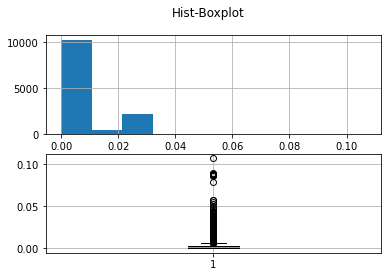

In [ ]:
print(df.shape)
preview_dataset(df)

## **Transformations**

#### Train-test split

In [ ]:
df.head()

,Kingdom,DNAtype,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,9,0,1995,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,9,0,1474,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,9,0,4862,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,9,0,1915,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,9,0,22831,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [ ]:
X = df.drop(["Kingdom",	"DNAtype"], axis=1)
y = df["Kingdom"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Balancing

#### Transformation

In [ ]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Feature selection

# **Model Classifier**

Extra Trees, Gradient Boosting, Hist Gradient Boosting,
Stacking, y Voting.

## **Random Forest Classifier**

### Tuning the hyper-parameters

In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"], 
    "max_depth": range(2, 20, 2),
    # "min_samples_split": [2, 4, 8],
    # "max_features": ["auto", "sqrt", "log2"],
    # "max_leaf_nodes": [2, 4, 8, None],
    # "class_weight": ["balanced", "balanced_subsample", None],
    "max_samples": [0.3, 0.5, 0.6]
}

#### HalvingGridSearchCV

In [ ]:
clf = RandomForestClassifier(random_state=1)
hgs = HalvingGridSearchCV(estimator=clf,
                         param_grid=param_grid,
                         resource="n_estimators",
                         max_resources=100,
                         cv=5,
                         scoring="accuracy",
                         random_state=42,
                         n_jobs=-1)
hgs.fit(X_train, y_train)
print(hgs.best_score_)
print(hgs.score(X_train, y_train))
print(hgs.score(X_test, y_test))
hgs.best_params_

0.8860066586004287
0.998939145529945
0.8885460856151176


{'criterion': 'entropy',
 'max_depth': 16,
 'max_samples': 0.6,
 'n_estimators': 81}

#### HalvingRandomSearchCV

In [ ]:
clf = RandomForestClassifier(random_state=1)
np.random.seed(1)

hrs = HalvingRandomSearchCV(estimator=clf,
                           param_distributions=param_grid,
                           resource="n_estimators",
                           max_resources=100,
                           cv=5,
                           scoring="accuracy",
                           random_state=42,
                           n_jobs=-1)
hrs.fit(X_train, y_train)
print(hrs.best_score_)
print(hrs.score(X_train, y_train))
print(hrs.score(X_test, y_test))
hrs.best_params_

#### GridSearchCV

In [ ]:
clf = RandomForestClassifier(random_state=1)
gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring="accuracy",
                  n_jobs=-1,
                  cv=5,
                  verbose=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))
gs.best_params_

#### RandomizedSearchCV

In [ ]:
clf = RandomForestClassifier(random_state=1)
rs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=param_grid, 
                        n_iter=20,
                        scoring="accuracy",
                        n_jobs=-1,
                        cv=5,
                        random_state=42)
rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.score(X_train, y_train))
print(rs.score(X_test, y_test))
pprint(rs.best_params_)

### Select best/Validation

In [ ]:
model = gs.best_estimator_

df_val = validation_multi(model, X_train, y_train, X_test, y_test)
df_val.head()

## **Extra Trees**

### Tuning the hyper-parameters

In [ ]:
param_grid = {
    "n_estimators": np.arange(10, 300, 50),
    ##"criterion": ["gini", "entropy", "log_loss"], 
    "max_depth": np.arange(2, 21, 2),
    # "min_samples_split": [2, 4, 8],
    # "max_features": ["auto", "sqrt", "log2"],
    "max_leaf_nodes": [2, 4, 8, None],
    "bootstrap": [True],
    # "class_weight": ["balanced", "balanced_subsample", None],
    "max_samples": [0.3, 0.5, 0.6, 1.0]
}

#### GridSearchCV

In [ ]:
et = ExtraTreesClassifier(random_state=42)
gs_et = GridSearchCV(estimator=et, 
                     param_grid=param_grid, 
                     scoring="roc_auc_ovr",
                     n_jobs=-1,
                     cv=5,
                     verbose=1,
                     error_score="raise")
gs_et.fit(X_train, y_train)
print(gs_et.best_score_)
print(gs_et.score(X_train, y_train))
print(gs_et.score(X_test, y_test))
gs_et.best_params_

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
0.9909712457921158
0.9999999946660942
0.9909340631641648


{'bootstrap': True,
 'max_depth': 20,
 'max_leaf_nodes': None,
 'max_samples': 1.0,
 'n_estimators': 260}

### Select best/Validation

In [ ]:
best_et = gs_et.best_estimator_

df_val_et = validation_multi(best_et, X_train, y_train, X_test, y_test)
df_val_et.head()

,Accuracy,Precision,Recall,AUC,Cross
Train,0.999904,0.999904,0.999904,1.000000,0.885234
Test,0.889703,0.889703,0.889703,0.990934,0.834942


## **Gradient Boosting**

### Tuning the hyper-parameters

In [ ]:
param_grid = {
    ##"loss": ["log_loss", "deviance", "exponential"],
    # "learning_rate": [0.001, 0.01, 0.1, 0.3, 1.0],
    #"n_estimators": np.arange(10, 101, 10),
    ##"criterion": ["friedman_mse", "squared_error", "mse"], 
    # "min_samples_split": [2, 4, 8],
    "max_depth": np.arange(2, 21, 2),
    # "max_features": ["auto", "sqrt", "log2"],
    # "max_leaf_nodes": [2, 4, 8, None],
}

#### GridSearchCV

In [ ]:
gb = GradientBoostingClassifier(random_state=42)
gs_gb = GridSearchCV(estimator=gb, 
                     param_grid=param_grid, 
                     scoring="roc_auc_ovr",
                     n_jobs=-1,
                     cv=5,
                     verbose=2)
gs_gb.fit(X_train, y_train)
print(gs_gb.best_score_)
print(gs_gb.score(X_train, y_train))
print(gs_gb.score(X_test, y_test))
gs_gb.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........................................max_depth=8; total time= 7.1min
[CV] END ........................................max_depth=8; total time= 7.1min
[CV] END .......................................max_depth=10; total time= 8.5min
[CV] END .......................................max_depth=10; total time= 8.5min
[CV] END .......................................max_depth=10; total time= 8.5min
[CV] END .......................................max_depth=10; total time= 8.5min
[CV] END .......................................max_depth=10; total time= 8.5min
[CV] END .......................................max_depth=12; total time= 9.2min
[CV] END .......................................max_depth=12; total time= 9.2min
[CV] END .......................................max_depth=12; total time= 9.3min
[CV] END .......................................max_depth=12; total time= 9.5min
[CV] END .......................................

{'max_depth': 6}

### Select best/Validation

In [ ]:
best_gb = gs_gb.best_estimator_

df_val_gb = validation_multi(best_gb, X_train, y_train, X_test, y_test)
df_val_gb.head()

[CV] END ........................................max_depth=8; total time= 7.0min
[CV] END .......................................max_depth=20; total time= 9.2min
[CV] END ........................................max_depth=8; total time= 7.0min
[CV] END .......................................max_depth=20; total time= 9.3min
[CV] END ........................................max_depth=8; total time= 7.0min
[CV] END .......................................max_depth=20; total time= 9.5min


,Accuracy,Precision,Recall,AUC,Cross
Train,1.000000,1.000000,1.000000,1.000000,0.901244
Test,0.916699,0.916699,0.916699,0.990082,0.851522


## **Hist Gradient Boosting**

### Tuning the hyper-parameters

In [ ]:
param_grid = {
    # "loss": ["log_loss", "auto", "binary_crossentropy", "categorical_crossentropy"],
    # "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.3, 1.0],
    "max_iter": np.arange(10, 101, 10),
    "max_depth": np.arange(2, 21, 2)
}

#### GridSearchCV

In [ ]:
hgb = HistGradientBoostingClassifier(random_state=42)
gs_hgb = GridSearchCV(estimator=hgb, 
                      param_grid=param_grid, 
                      scoring="roc_auc_ovr",
                      n_jobs=-1,
                      cv=5,
                      verbose=2)
gs_hgb.fit(X_train, y_train)
print(gs_hgb.best_score_)
print(gs_hgb.score(X_train, y_train))
print(gs_hgb.score(X_test, y_test))
gs_hgb.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
9.932805007641893e-01
9.997726394673052e-01
9.923862020600644e-01


{'max_depth': 6, 'max_iter': 100}

### Select best/Validation

In [ ]:
best_hgb = gs_hgb.best_estimator_

df_val_hgb = validation_multi(best_hgb, X_train, y_train, X_test, y_test)
df_val_hgb.head()

,Accuracy,Precision,Recall,AUC,Cross
Train,0.991706,0.991706,0.991706,0.999773,0.919279
Test,0.921712,0.921712,0.921712,0.992386,0.870421


## **Stacking**

### Tuning the hyper-parameters

In [ ]:
param_grid = {
    "loss": ["log_loss", "auto", "binary_crossentropy", "categorical_crossentropy"],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.3, 1.0],
    "max_iter": np.arange(10, 101, 10),
    "max_depth": np.arange(2, 21, 2)
}

#### GridSearchCV

In [ ]:
hgb = HistGradientBoostingClassifier(random_state=42)
gs_hgb = GridSearchCV(estimator=hgb, 
                      param_grid=param_grid, 
                      scoring="accuracy",
                      n_jobs=-1,
                      cv=5,
                      verbose=2)
gs_hgb.fit(X_train, y_train)
print(gs_hgb.best_score_)
print(gs_hgb.score(X_train, y_train))
print(gs_hgb.score(X_test, y_test))
gs_hgb.best_params_

### Select best/Validation

In [ ]:
best_hgb = gs_hgb.best_estimator_

df_val_hgb = validation_multi(best_hgb, X_train, y_train, X_test, y_test)
df_val_hgb.head()

## **Voting**

### Tuning the hyper-parameters

In [ ]:
param_grid = {
    "loss": ["log_loss", "auto", "binary_crossentropy", "categorical_crossentropy"],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.3, 1.0],
    "max_iter": np.arange(10, 101, 10),
    "max_depth": np.arange(2, 21, 2)
}

#### GridSearchCV

In [ ]:
hgb = HistGradientBoostingClassifier(random_state=42)
gs_hgb = GridSearchCV(estimator=hgb, 
                      param_grid=param_grid, 
                      scoring="accuracy",
                      n_jobs=-1,
                      cv=5,
                      verbose=2)
gs_hgb.fit(X_train, y_train)
print(gs_hgb.best_score_)
print(gs_hgb.score(X_train, y_train))
print(gs_hgb.score(X_test, y_test))
gs_hgb.best_params_

### Select best/Validation

In [ ]:
best_hgb = gs_hgb.best_estimator_

df_val_hgb = validation_multi(best_hgb, X_train, y_train, X_test, y_test)
df_val_hgb.head()